# Variant analysis for Pseudomonas 14 : Group By genes

Int his notebook we are goingo to analyse the merged output files of SNPeff variants annotation and SnpSift fields extract.

In [1]:
!conda create -y -n p14 biopython


Fetching package metadata ...^C
Traceback (most recent call last):
  File "/Users/delphinel/anaconda/envs/jupyterserv/bin/conda", line 6, in <module>
    sys.exit(conda.cli.main())
  File "/Users/delphinel/anaconda/lib/python2.7/site-packages/conda/cli/main.py", line 182, in main
    return conda_exception_handler(_main, *args)
  File "/Users/delphinel/anaconda/lib/python2.7/site-packages/conda/exceptions.py", line 640, in conda_exception_handler
    return_value = func(*args, **kwargs)
  File "/Users/delphinel/anaconda/lib/python2.7/site-packages/conda/cli/main.py", line 140, in _main
    exit_code = args.func(args, p)
  File "/Users/delphinel/anaconda/lib/python2.7/site-packages/conda/cli/main_create.py", line 68, in execute
    install(args, parser, 'create')
  File "/Users/delphinel/anaconda/lib/python2.7/site-packages/conda/cli/install.py", line 231, in install
    unknown=index_args['unknown'], prefix=prefix)
  File "/Users/delphinel/anaconda/lib/python2.7/site-packages/conda/com

In [16]:
!source activate pa14

Installation of necessary libraries

In [417]:
!conda install -y -c anaconda biopython
!conda install -y -c anaconda networkx 
!conda install -y -c biocore mafft 
!conda install -y -c conda-forge seaborn 
!conda install -y -c bioconda ete3 
!conda install -y pandasql
!conda install -y -c anaconda networkx 
!conda install -y -c anaconda scikit-learn 
!conda install -y -c anaconda pygraphviz 
!conda install -y -c anaconda scikit-bio 

Fetching package metadata .................
Solving package specifications: .

Package plan for installation in environment /Users/delphinel/anaconda/envs/jupyterserv:

The following packages will be UPDATED:

    biopython: 1.70-py27h1702cab_0 anaconda --> 1.71-py27h1702cab_0 anaconda

biopython-1.71 100% |################################| Time: 0:00:00   5.69 MB/s       | ETA:  0:00:00   4.42 MB/s
Fetching package metadata .................
Solving package specifications: .

# All requested packages already installed.
# packages in environment at /Users/delphinel/anaconda/envs/jupyterserv:
#
networkx                  2.1                      py27_0    anaconda
Fetching package metadata .................
Solving package specifications: .

# All requested packages already installed.
# packages in environment at /Users/delphinel/anaconda/envs/jupyterserv:
#
mafft                     7.245                         0    biocore
Fetching package metadata ...............
Solving package spec

Importation of necessary libraries

In [17]:
import pandas as pd
from pandasql import *
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import re
from Bio import Phylo
from Bio.Phylo.TreeConstruction import DistanceCalculator
from Bio import AlignIO
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor
import pylab
from ete3 import Tree, TreeStyle, NodeStyle, TextFace, faces, AttrFace
pysqldf = lambda q: sqldf(q, globals())
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics.pairwise import euclidean_distances
import scipy
from scipy.spatial.distance import squareform, pdist
from Bio.Phylo.TreeConstruction import _Matrix
from Bio.Phylo.TreeConstruction import DistanceMatrix
import skbio
import os
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import SeqFeature, FeatureLocation
from Bio import SeqIO


### Plotting Strand Bias

The strand Bias is a sequencing bias that result in an inbalance of infered genotype from the positive and negative strand. We want to eliminate the variants where the strand bias is too high.

The strand bias has been calculated on Galaxy using the tool "compute on column" using the following equations (from https://bmcgenomics.biomedcentral.com/articles/10.1186/1471-2164-13-666) :  


Calculation Strand Bias : 

 a -  Forward strand reference allele = SRF column (5) 

 b - Forward strand non reference allele = SAF column (7) 

 c - Reverse strand reference allele = SRR column (6) 

 d - Reverse strand non reference allele = SAR column (8) 

``` SB: SB is defined as ∣∣(b/(a+b))−(d/(c+d))∣∣/((b+d)/(a+b+c+d))
SB =  ∣∣(SAF/(SRF+SAF))−(SAR/(SRR+SAR))∣∣/((SAF+SAR)/(SRF+SAF+SRR+SAR))
SB =  abs((SAF/(SRF+SAF))−(SAR/(SRR+SAR)))/((SAF+SAR)/(SRF+SAF+SRR+SAR))
SB =  abs(((c6/(c6+c8))-(c7/(c9+c7)))) / ((c6+c7)/(c9+c6+c7+c8) ) (Formula applied in Compute Column tool)```

Import of the file resulting of collection collapse snpsift output collection, and plotting of the Strand Bias repartition

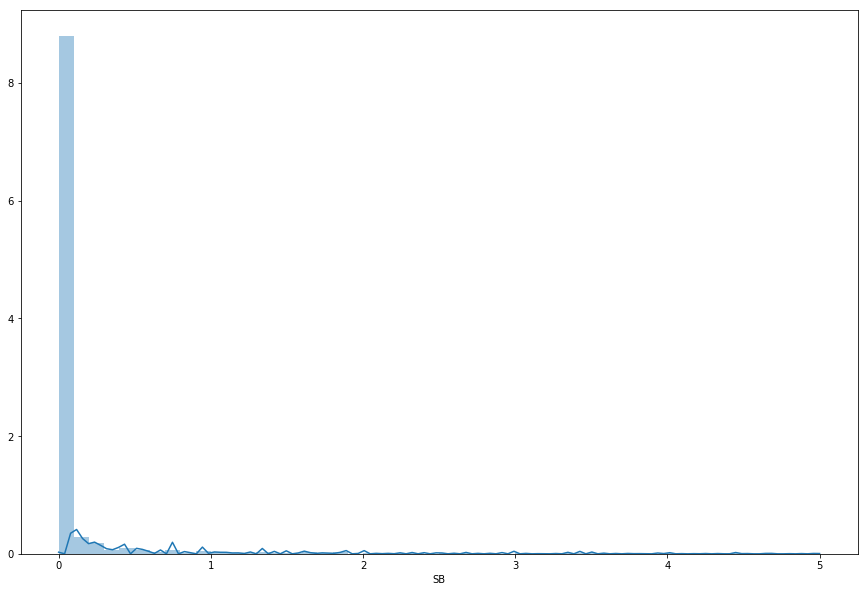

In [155]:
collapsed = pd.read_table('Galaxy3714-[Collapse_Collection_on_data_3709,_data_3708,_and_others].tabular')

fig, ax = plt.subplots( nrows=1, ncols=1 ,figsize=(15, 10) ) 
sns.distplot(collapsed["SB"]);


We can see that the Strand Bias is in majority <2 , we therefore applied a filter to the snpsift output to select the variants with a Strand Bias <2 

##  Import and cleaning of input files

The input files has been obtained by applying several filters on the variants annotation : 
 * EFFECT!='intergenic_region' : Keep only the variants in intragenic regions
 * ',' not in ALT
 * strand_bias<2
        

Import files into the notebook : 
 * The joined file is the file resulting of a collumn join on snpsift output collection

In [13]:
joined = pd.read_table('Galaxy3713-[Column_Join_on_data_3709,_data_3708,_and_others].tabular')



The output of SnpSift returns a tabulated files with header containing cracayers that may cause problems further into the analysis. We therefore need to replace the problematic caracters in the column names

In [14]:
for i in joined.columns.values : 
    joined=joined.rename(index=str, columns={i:i.replace('.','_').replace('[*]_','_')})


As we may need the original version of the data later in the analysis we are creating a working copy of the Dataframe.

In [15]:
sequences=joined.copy()

Let's take a look at the data

In [16]:
sequences.head()

,POS,SRR5363633_wtP_fq_CHROM,SRR5363633_wtP_fq_REF,SRR5363633_wtP_fq_ALT,SRR5363633_wtP_fq_QUAL,SRR5363633_wtP_fq_SAF,SRR5363633_wtP_fq_SAR,SRR5363633_wtP_fq_SRF,SRR5363633_wtP_fq_SRR,SRR5363633_wtP_fq_SAP,...,SRR5363715_cip_fq_SRP,SRR5363715_cip_fq_EPP,SRR5363715_cip_fq_DP,SRR5363715_cip_fq_EFF_GENEID,SRR5363715_cip_fq_EFF_GENE,SRR5363715_cip_fq_EFF_EFFECT,SRR5363715_cip_fq_EFF_AA,SRR5363715_cip_fq_EFF_IMPACT,SRR5363715_cip_fq_EFF_FUNCLASS,SRR5363715_cip_fq_SB
0,100578,.,.,.,.,.,.,.,.,.,...,.,.,.,.,.,.,.,.,.,.
1,1016267,.,.,.,.,.,.,.,.,.,...,.,.,.,.,.,.,.,.,.,.
2,1026509,.,.,.,.,.,.,.,.,.,...,.,.,.,.,.,.,.,.,.,.
3,1026747,.,.,.,.,.,.,.,.,.,...,.,.,.,.,.,.,.,.,.,.
4,1027040,.,.,.,.,.,.,.,.,.,...,.,.,.,.,.,.,.,.,.,.


You can see that the dataframe has an big number of collumns, including the information in 15 columns for each variants. Most of the frames are empty, meaning the sample does not present the variant.
Several information are redundant of won't be used in this analysis. In order to avoid carrying along data we won't need, we are creating lists of the data we won't use to filter out the dataFrame : 
Columns of interest :
 * A list of columns containing the sequence of reference
 * A list of collumn contining the gene impacted by the variation
 * A list of collumn contining the alternative sequence
 * A list containing the collumns we will need for this analysis


In [17]:
regexREF=re.compile(".*(REF).*") # List of columns containing the reference allele of the variant
listREF=filter(regexREF.match,joined.columns.values)
listsamples= [ i.replace('_fq_REF','') for i in listREF ] #list of sample names
regexGENE=re.compile(".*(GENE).*") # List of columns containing the gene impacted by the variant
listGENE=filter(regexGENE.match,joined.columns.values)
regexALT=re.compile(".*(ALT).*") # List of columns containing the alternative allele of the variant
listALT=filter(regexALT.match,joined.columns.values)
regexclean=re.compile(".*(_GENE)|(IMPACT)|(FUNCLASS).*") # List of columns we want to filter out (Neither gene impacted, impact nor functionnal class)
listrefsalts=filter(lambda i: not regexclean.search(i),sequences.columns.values)


Now that we identified our interesting collumn, we can delete the other ones

In [18]:
for i in listrefsalts[1:]:
    del sequences[i]


KeyError: 'SRR5363633_wtP_fq_EFF_IMPACT_1'

In [22]:
sequences.head()

,POS,SRR5363633_wtP_fq_EFF_GENEID,SRR5363633_wtP_fq_EFF_GENE,SRR5363633_wtP_fq_EFF_IMPACT,SRR5363633_wtP_fq_EFF_FUNCLASS,SRR5363634_con_fq_EFF_GENEID,SRR5363634_con_fq_EFF_GENE,SRR5363634_con_fq_EFF_IMPACT,SRR5363634_con_fq_EFF_FUNCLASS,SRR5363635_con_fq_EFF_GENEID,...,SRR5363713_cip_fq_EFF_IMPACT,SRR5363713_cip_fq_EFF_FUNCLASS,SRR5363714_cip_fq_EFF_GENEID,SRR5363714_cip_fq_EFF_GENE,SRR5363714_cip_fq_EFF_IMPACT,SRR5363714_cip_fq_EFF_FUNCLASS,SRR5363715_cip_fq_EFF_GENEID,SRR5363715_cip_fq_EFF_GENE,SRR5363715_cip_fq_EFF_IMPACT,SRR5363715_cip_fq_EFF_FUNCLASS
0,100578,.,.,.,.,.,.,.,.,.,...,.,.,.,.,.,.,.,.,.,.
1,1016267,.,.,.,.,.,.,.,.,.,...,.,.,.,.,.,.,.,.,.,.
2,1026509,.,.,.,.,.,.,.,.,.,...,.,.,.,.,.,.,.,.,.,.
3,1026747,.,.,.,.,.,.,.,.,.,...,.,.,.,.,.,.,.,.,.,.
4,1027040,.,.,.,.,.,.,.,.,.,...,.,.,.,.,.,.,.,.,.,.


We now reduced the number of collumns to 247.

In this analysis we are interested in clustering the samples depending on the genes that are modified and how much they are modified.
In order to do that we want to groupe the variants per genes and provide a modification score.


The first Step is to create an additionnal column to the dataframe to store the information of the impacted gene, and then parse the dataframe to find the gene impacted by each variant.


In [23]:
listsamples= [ i.replace('_fq_REF','') for i in listREF ]
sequences['GENE']="NaN"
for i, row in sequences.iterrows() :
    for j in listGENE :
        if row[j]!='.':
            sequences.loc[i,('GENE')]=row[j]
            break

Now that we have regrouped the gene information in a single collumn we can delete the collumns containing the gene impacted for each sample, now redundant with the 'GENE' column.

In [24]:
for i in listGENE:
    del sequences[i]



Now that we have the gene impacted for each variant, we need to quantify the impact of each variant on the gene. in order to do that we attributed a number reflecting the strength of each type of impact.

In the Dataframe, we are therefore replacing the "IMPACT" column with numerical values depending on the strength of the effect : 
 * No variant results on a value of 0 impact
 * A Low impact variant with a "SILENT" Functional class results on a value of 0 impact
 * A Low impact variant results on a value of 100 impact
 * A Medium impact variant results on a value of 200 impact
 * A High impact variant results on a value of 300 impact
 * A Modifier variant results on a value of 50 impact

From http://snpeff.sourceforge.net/SnpEff_manual.html : 
    
| Impact | Meaning | Example |
| ------------ | ----------- | -----------: |
| HIGH | The variant is assumed to have high (disruptive) impact in the protein, probably causing protein truncation, loss of function or triggering nonsense mediated decay. | stop_gained, frameshift_variant |
| MODERATE      |   A non-disruptive variant that might change protein effectiveness.    | missense_variant, inframe_deletion |
| LOW |     Assumed to be mostly harmless or unlikely to change protein behavior.      | synonymous_variant |
| MODIFIER     |  Usually non-coding variants or variants affecting non-coding genes, where predictions are difficult or there is no evidence of impact.  | exon_variant, downstream_gene_variant |


In [25]:
for i, row in sequences.iterrows() :
    for j in listsamples :
        if row[j+'_fq_EFF_IMPACT']=='.':
            sequences.loc[i,(j+'_fq_EFF_IMPACT')]=0
        elif 'LOW'in  row[j+'_fq_EFF_IMPACT'] and 'SILENT'in row[j+'_fq_EFF_FUNCLASS'] :
            sequences.loc[i,(j+'_fq_EFF_IMPACT')]=0
        elif 'LOW'in  row[j+'_fq_EFF_IMPACT'] :
            sequences.loc[i,(j+'_fq_EFF_IMPACT')]=100
        elif 'MODERATE'in  row[j+'_fq_EFF_IMPACT'] :
            sequences.loc[i,(j+'_fq_EFF_IMPACT')]=200
        elif 'HIGH'in  row[j+'_fq_EFF_IMPACT'] :
            sequences.loc[i,(j+'_fq_EFF_IMPACT')]=300
        else : 
            sequences.loc[i,(j+'_fq_EFF_IMPACT')]=50
        

 Now that we are done using the functionnal class information, we can remove the the funclass columns.

In [26]:
for j in listsamples :
    del sequences[j+'_fq_EFF_FUNCLASS']

Let's see what our data look like now

In [27]:
sequences.head()

,POS,SRR5363633_wtP_fq_EFF_IMPACT,SRR5363634_con_fq_EFF_IMPACT,SRR5363635_con_fq_EFF_IMPACT,SRR5363636_con_fq_EFF_IMPACT,SRR5363637_con_fq_EFF_IMPACT,SRR5363638_con_fq_EFF_IMPACT,SRR5363639_con_fq_EFF_IMPACT,SRR5363640_con_fq_EFF_IMPACT,SRR5363641_con_fq_EFF_IMPACT,...,SRR5363707_cip_fq_EFF_IMPACT,SRR5363708_cip_fq_EFF_IMPACT,SRR5363709_cip_fq_EFF_IMPACT,SRR5363710_cip_fq_EFF_IMPACT,SRR5363711_cip_fq_EFF_IMPACT,SRR5363712_cip_fq_EFF_IMPACT,SRR5363713_cip_fq_EFF_IMPACT,SRR5363714_cip_fq_EFF_IMPACT,SRR5363715_cip_fq_EFF_IMPACT,GENE
0,100578,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,tssC1
1,1016267,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,PA14_11730
2,1026509,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,PA14_11845
3,1026747,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,PA14_11845
4,1027040,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,PA14_11845


We have a dataframe containing the position of the variant, the gene impacted, and for each sample the strengh of the impact.

We now whant to create a Matrix grouping the variants by gene impacted : the different variant impacts are added for a result reflecting the global impact of all variants on one gene.

In [28]:
#Creation of an empty matri with header = list of samples
matgene=pd.DataFrame(columns=sequences.columns.values[1:-1])
# Group rows by gene, summing the row content for collumns contining variants
matgene = sequences.groupby(['GENE'])[sequences.columns.values[1:-1]].sum()

Let's take a look at our data

In [29]:
matgene.head()

,SRR5363633_wtP_fq_EFF_IMPACT,SRR5363634_con_fq_EFF_IMPACT,SRR5363635_con_fq_EFF_IMPACT,SRR5363636_con_fq_EFF_IMPACT,SRR5363637_con_fq_EFF_IMPACT,SRR5363638_con_fq_EFF_IMPACT,SRR5363639_con_fq_EFF_IMPACT,SRR5363640_con_fq_EFF_IMPACT,SRR5363641_con_fq_EFF_IMPACT,SRR5363642_con_fq_EFF_IMPACT,...,SRR5363706_cip_fq_EFF_IMPACT,SRR5363707_cip_fq_EFF_IMPACT,SRR5363708_cip_fq_EFF_IMPACT,SRR5363709_cip_fq_EFF_IMPACT,SRR5363710_cip_fq_EFF_IMPACT,SRR5363711_cip_fq_EFF_IMPACT,SRR5363712_cip_fq_EFF_IMPACT,SRR5363713_cip_fq_EFF_IMPACT,SRR5363714_cip_fq_EFF_IMPACT,SRR5363715_cip_fq_EFF_IMPACT
GENE,,,,,,,,,,,,,,,,,,,,,
".,.",300,300,300,300,300,300,300,300,300,300,...,300,300,300,300,300,300,300,300,300,300
NaN,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PA14_00050,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,200,0,200
PA14_00490,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100
PA14_00510,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We now have a Dataframe containing only the amount of modification of each gene in each sample. We are going to use these data to build a distance matrix.

In [30]:
#distance =  lambda column1, column2: pd.np.linalg.norm(column1 - column2) # Euclidian Distance
#distance = lambda column1, column2: scipy.stats.pearsonr(column1, column2)[0] # Pearson correlation coefficient
distance = lambda column1, column2: (column1 - column2).abs().sum() / len(column1) # % Difference
distdf = matgene.apply(lambda col1: matgene.apply(lambda col2: distance(col1, col2)))


The function that we want to use to builde a hierarchical tree doesn't take dataframes as imput. We therefore change the type and format of the distance matrix.

In [31]:
dstmattril=np.tril(distdf) # make it a lower triangular matrix
namessample= [str(x).replace("_fq_EFF_IMPACT","") for x in distdf.columns.values] #Remove unnecessary parts of sample names for more readability
# make it a list of lists 
dstmattril= [list(x) for x in dstmattril] 
altDistmat=list()
for i in range(0,len(distdf.columns.values)):
    altDistmat.append(dstmattril[i][:i+1])

Now that we have our distance matrix at the right format, we are building a clustering tree from the distance matrix (Here using neighor joining algorithm) and save the tree in newick format in a file

In [32]:
distmattree = DistanceMatrix(names=namessample, matrix=altDistmat)
constructor = DistanceTreeConstructor()
tree = constructor.nj(distmattree)
Phylo.write(tree,'test.nwk', 'newick')

1

### Draw Tree from a Newick File

We now are going to use the newick tree file to display the tree in jupyter notebook. 

First, we create a dictionnary to link every sample to a color depending on its condition. This dictionary will be used to color the tree and improve its readability.

In [33]:
condlist=list()
for i in namessample:
    condition=i[-3:]
    if condition not in condlist:
        condlist.append(condition)
colors=['red','blue','purple','black','pink','green','lightblue','brown','yellow', 'orange']
colcondDisct={}
for i in range(len(condlist)):
    colcondDisct[condlist[i]]=colors[i]
colorleaves= {}
for i in namessample:
    condition=i[-3:]
    colorleaves[i]=colcondDisct[condition]
    

Then we open the tree and set the drawing style, title, leaves color. We also set the wild type sample as an outgroup. Finally we display the tree in the notebook.

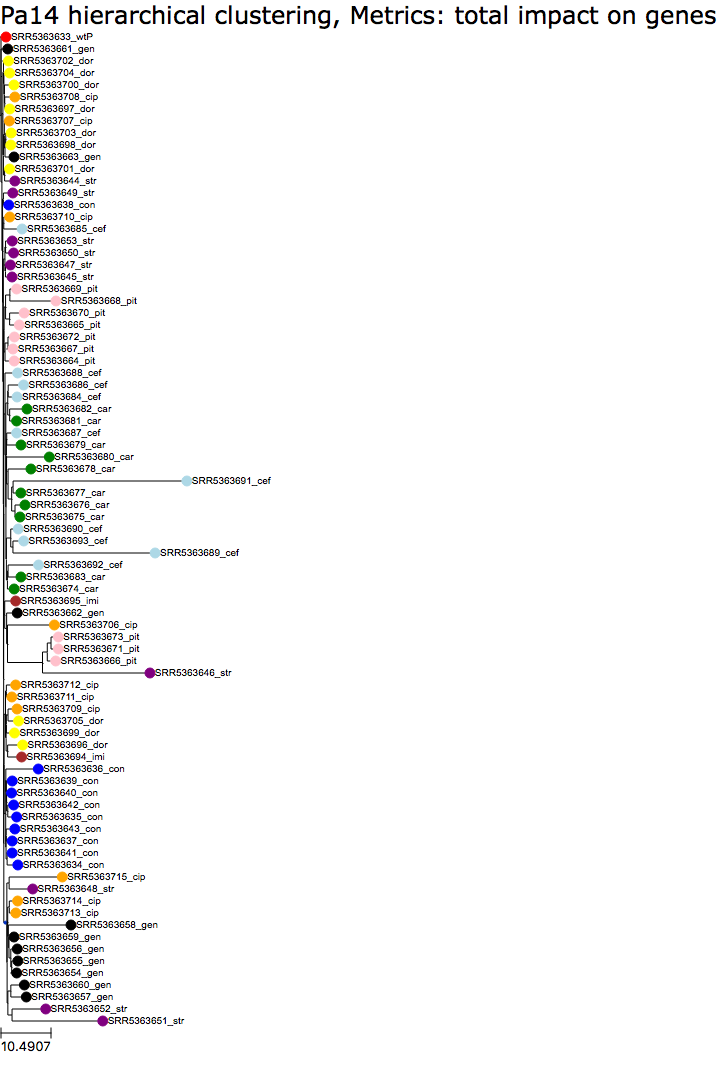

In [34]:
tree = Tree("test.nwk", format=1)
ts = TreeStyle()
ts.title.add_face(TextFace("Pa14 hierarchical clustering, Metrics: total impact on genes", fsize=24), column=0)
#ts.mode="c"
#ts.show_branch_length = False
ts.show_branch_support = False

for node in tree.traverse():
    node.img_style['size']=0
    if node.is_leaf():
        node.img_style['size']=10
        node.img_style["fgcolor"] = colorleaves[node.name]
                                                 
tree.set_outgroup("SRR5363633_wtP") # Set the wildtype as outgroup

tree.render("%%inline", tree_style=ts)

The samples are very close so the tree is very compacted. In order to visualize the clusters more clearly, we convert the tree to ultrametric.

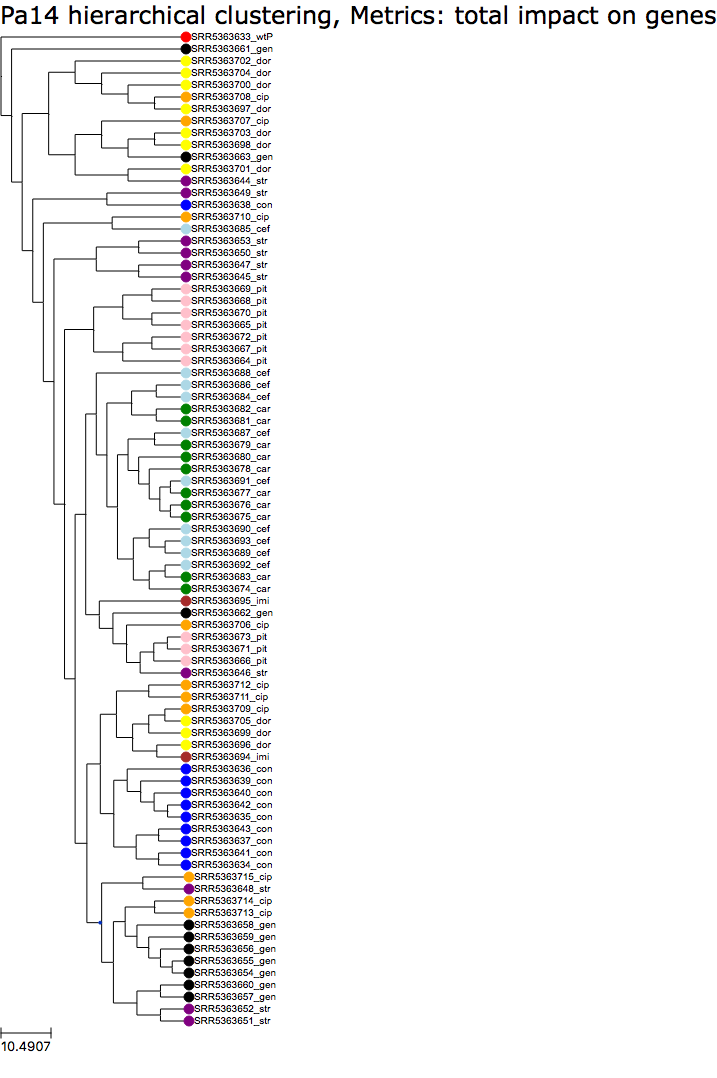

In [43]:
tree.convert_to_ultrametric(strategy='balanced')
tree.render("%%inline", tree_style=ts)


## Analyse of highly mutated samples (long branch support) in cef and str experiment

We noticed from the trees that despite most of the branch bein very short due to the proximity of all samples, three samples have distinctively longer branches. We want to investigate why thesesamples are so different from the others.

We start with importing the collapsed collection of snpsift output files and replacing caracters that could cause problems in the future analysis.

In [215]:
collapsed_all = pd.read_table('Galaxy3714-[Collapse_Collection_on_data_3709,_data_3708,_and_others].tabular')
var=collapsed_all.rename(index=str, columns={"EFF[*].CODON":"CODON","EFF[*].GENE":"GENE","EFF[*].EFFECT":"EFFECT","EFF[*].EFFECT":"EFFECT","EFF[*].AA":"AA","EFF[*].IMPACT":"IMPACT","EFF[*].IMPACT.1":"IMPACT1", "EFF[*].FUNCLASS" :"FUNCLASS"})
var['condition']="NaN"
for i, row in var.iterrows() :
    var.loc[i,('condition')]=row['Sample'].split('_')[1].replace(".fq","")
    

We import the reference genbank file to get the functionnal information about the gene impacted by the variants.

In [216]:

# get all sequence records for the specified genbank file
recs = [rec for rec in SeqIO.parse("Pseudomonas_aeruginosa_UCBPP-PA14_109.gbk.genbank", "genbank")]


We parse the file to add information about the gene product in the dataframe

In [217]:
dicFunctAll={}
for rec in recs:
    feats = [feat for feat in rec.features if feat.type == "CDS"]
    for feat in feats:
        dicFunctAll[feat.qualifiers['locus_tag'][0]]=feat.qualifiers['product'][0]

var["product"]="NaN"
for i, row in var.iterrows() :
    locusTag=row['GENE'].split(",")[0]
    if locusTag in dicFunctAll.keys():
        var.loc[i,('product')]=dicFunctAll[locusTag]

Let's take a look at our data : we now have a collumn product containing the annotation information got from the genbank file.

In [218]:
var.head()

,Sample,CHROM,POS,REF,ALT,QUAL,SAF,SAR,SRF,SRR,...,DP,EFF[*].GENEID,GENE,EFFECT,AA,IMPACT,FUNCLASS,SB,condition,product
0,SRR5363633_wtP.fq,NC_008463,41753,TCGG,CCGA,1569.14,118,84,0,0,...,202,.,PA14_00490,synonymous_variant,p.209/c.621_624delTCGGinsCCGA,LOW,NONE,0.0,wtP,hemolysin activation/secretion protein
1,SRR5363633_wtP.fq,NC_008463,72440,T,C,12141.90,232,147,0,0,...,379,.,PA14_00740,missense_variant,p.Lys132Glu/c.394A>G,MODERATE,MISSENSE,0.0,wtP,lipoprotein
2,SRR5363633_wtP.fq,NC_008463,96307,A,C,11087.10,94,247,0,0,...,341,.,PA14_00970,synonymous_variant,p.Pro49Pro/c.147T>G,LOW,SILENT,0.0,wtP,hypothetical protein
3,SRR5363633_wtP.fq,NC_008463,96350,TTGTCCAGCGT,CTGGCCCGCGC,9875.42,97,150,0,0,...,250,.,PA14_00970,missense_variant,p.ThrLeuAspAsn32AlaArgAlaSer/c.94_104delACGCTG...,MODERATE,NONE,0.0,wtP,hypothetical protein
4,SRR5363633_wtP.fq,NC_008463,96391,ACA,GCC,7932.23,108,145,0,0,...,253,.,PA14_00970,missense_variant,p.Cys21Gly/c.61_63delTGTinsGGC,MODERATE,NONE,0.0,wtP,hypothetical protein


Let's now explore our data. We start by creating a sub sample of the dataframe containing only the conditions we want to explore for easier manupulation.


In [219]:
interestCond=pysqldf("SELECT * FROM var WHERE condition='cef' AND SB<2")

Let's count how many genes and positions are affected by sample.

Sample
SRR5363684_cef.fq     72
SRR5363685_cef.fq     75
SRR5363686_cef.fq     74
SRR5363687_cef.fq     72
SRR5363688_cef.fq     74
SRR5363689_cef.fq    154
SRR5363690_cef.fq     72
SRR5363691_cef.fq    176
SRR5363692_cef.fq     81
SRR5363693_cef.fq     76
Name: GENE, dtype: int64


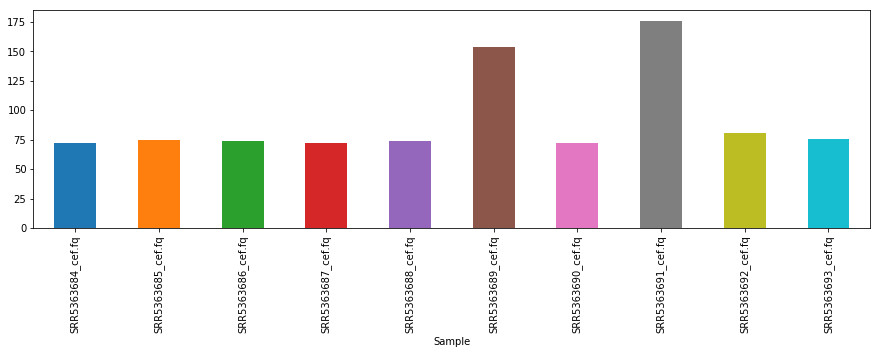

In [220]:
print pysqldf("SELECT * FROM interestCond WHERE condition='cef'").groupby("Sample")['GENE'].nunique()
fig, ax = plt.subplots( nrows=1, ncols=1 ,figsize=(15, 4) )  # create figure & 1 axis
pysqldf("SELECT * FROM interestCond WHERE condition='cef'").groupby("Sample")['GENE'].nunique().plot.bar()


Sample
SRR5363684_cef.fq    201
SRR5363685_cef.fq    203
SRR5363686_cef.fq    195
SRR5363687_cef.fq    199
SRR5363688_cef.fq    198
SRR5363689_cef.fq    309
SRR5363690_cef.fq    201
SRR5363691_cef.fq    320
SRR5363692_cef.fq    213
SRR5363693_cef.fq    204
Name: POS, dtype: int64


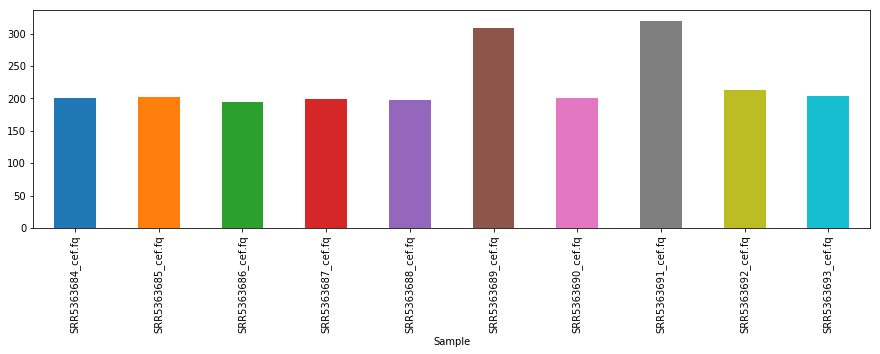

In [221]:
print pysqldf("SELECT * FROM interestCond WHERE condition='cef'").groupby("Sample")['POS'].nunique()
fig, ax = plt.subplots( nrows=1, ncols=1 ,figsize=(15, 4) )  # create figure & 1 axis
pysqldf("SELECT * FROM interestCond WHERE condition='cef'").groupby("Sample")['POS'].nunique().plot.bar()


We can see that our two samples of interest have a much larger number of variants and gene affected, while the other samples have about the same number of variants. We also notice that SRR5363689_cef and SRR5363691_cef have similar number of variants despite not clustering together on the tree.

Let's  continue our exploration.

Let's remove the variants that are present in the wild type and control to keep onlyt the variants that could be linked to the antibiotic resistance.

In [222]:
controlvarPOS=pysqldf("SELECT * FROM var WHERE condition IN ('wtP','con') ")['POS'].unique()
controlvarPOS=[str(x) for x in controlvarPOS] 
interestingVar=pysqldf("SELECT * FROM interestCond WHERE POS NOT IN ("+','.join(controlvarPOS)+")")


Let's now take a look at the remaining variants

Sample
SRR5363684_cef.fq      7
SRR5363685_cef.fq     12
SRR5363686_cef.fq      8
SRR5363687_cef.fq      6
SRR5363688_cef.fq      7
SRR5363689_cef.fq    131
SRR5363690_cef.fq      5
SRR5363691_cef.fq    148
SRR5363692_cef.fq     21
SRR5363693_cef.fq     14
Name: POS, dtype: int64


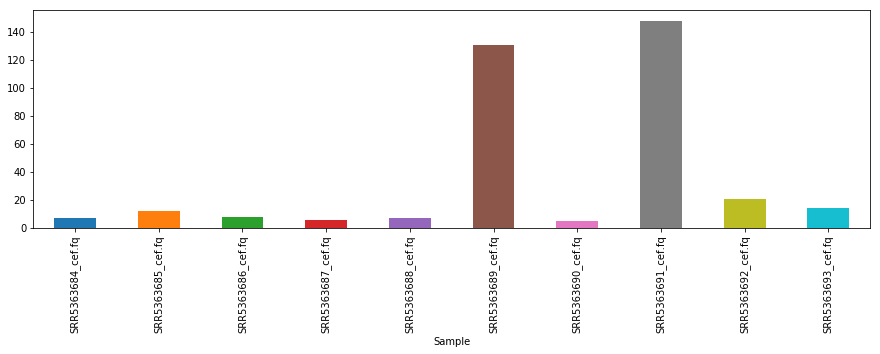

In [223]:
print pysqldf("SELECT * FROM interestingVar").groupby("Sample")['POS'].nunique()
fig, ax = plt.subplots( nrows=1, ncols=1 ,figsize=(15, 4) )  # create figure & 1 axis
pysqldf("SELECT * FROM interestingVar").groupby("Sample")['POS'].nunique().plot.bar()


Sample
SRR5363684_cef.fq      5
SRR5363685_cef.fq      8
SRR5363686_cef.fq      8
SRR5363687_cef.fq      6
SRR5363688_cef.fq      7
SRR5363689_cef.fq     93
SRR5363690_cef.fq      4
SRR5363691_cef.fq    115
SRR5363692_cef.fq     14
SRR5363693_cef.fq     10
Name: GENE, dtype: int64


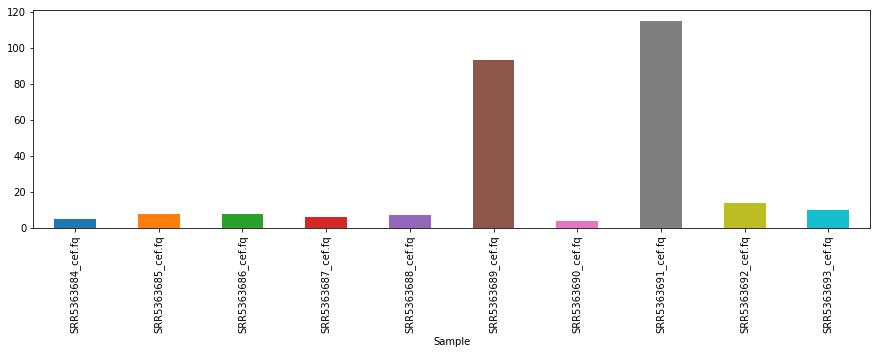

In [224]:
print pysqldf("SELECT * FROM interestingVar").groupby("Sample")['GENE'].nunique()
fig, ax = plt.subplots( nrows=1, ncols=1 ,figsize=(15, 4) )  # create figure & 1 axis
pysqldf("SELECT * FROM interestingVar").groupby("Sample")['GENE'].nunique().plot.bar()

We can se that when the other samples have few variations, SRR5363689_cef and SRR5363691_cef have about 150 variants affectig about 120 genes. Let's see if they are affecting the same genes.


In [230]:
interestingVar['Sample'].unique()

array([u'SRR5363684_cef.fq', u'SRR5363685_cef.fq', u'SRR5363686_cef.fq',
       u'SRR5363687_cef.fq', u'SRR5363688_cef.fq', u'SRR5363689_cef.fq',
       u'SRR5363690_cef.fq', u'SRR5363691_cef.fq', u'SRR5363692_cef.fq',
       u'SRR5363693_cef.fq'], dtype=object)

In [231]:
varA=pysqldf("SELECT * FROM interestingVar WHERE Sample='SRR5363689_cef.fq'")
varB=pysqldf("SELECT * FROM interestingVar WHERE Sample='SRR5363691_cef.fq'")

In [233]:
commonVarGenes =  list(set(varB['GENE'].unique()).intersection(varA['GENE'].unique())) #Intersection of gene list between the two samples.
commonVarGenes=[str(x) for x in commonVarGenes] 
commonVarProduct=[dicFunctAll[x] for x in commonVarGenes if x in dicFunctAll.keys()] 
print commonVarGenes
print commonVarProduct

['PA14_29690', '.', 'PA14_40260', 'PA14_43190', 'PA14_46640', 'PA14_48600', 'PA14_22730']
['hypothetical protein', 'hypothetical protein', 'oxidoreductase', 'siderophore receptor', 'AMP-binding protein', 'two-component sensor']


We can see that among the 120 gene affected in each sample, they only have 7 genes in common. This result explain why they don't cluster together on the clustering tree. 

This also show that the variants outside of this list are unlikely to be linked to antibiotic resistance. 

We are now interested in knowing why these variants show such a high level of mutations.
We now want to look at the gene affected to find which could have caused these mutations.

In [234]:
varA['product'].unique()

array([u'TssG1', u'NaN',
       u'monofunctional biosynthetic peptidoglycan transglycosylase',
       u'tail fiber protein', u'hypothetical protein', u'MFS transporter',
       u'transcription antitermination protein NusB', u'protein kinase',
       u'(dimethylallyl)adenosine tRNA methylthiotransferase',
       u'nitrite extrusion protein 1',
       u'PTS system N-acetylglucosamine-specific IIBC component',
       u'chemotaxis transducer',
       u'chemotaxis sensor/effector fusion protein',
       u'tetrahydrodipicolinate succinylase', u'ribonuclease HII',
       u'DNA mismatch repair protein MutS', u'transcriptional regulator',
       u'phosphonate ABC transporter permease', u'two-component sensor',
       u'heat-shock protein IbpA', u'pilus assembly protein',
       u'oxidoreductase', u'magnesium chelatase',
       u'precorrin-3 methylase CobJ',
       u'LysR family transcriptional regulator',
       u'phenylalanyl-tRNA synthetase subunit beta',
       u'NADH dehydrogenase, FAD-cont

In [235]:
varB['product'].unique()

array([u'epsilon subunit of malonate decarboxylase',
       u'ArsR family transcriptional regulator',
       u'deoxyribonucleotide triphosphate pyrophosphatase',
       u'methylesterase', u'hypothetical protein',
       u'phosphate transporter', u'NaN', u'two-component sensor',
       u'transmembrane sensor', u'outer membrane protein',
       u'nucleoid-associated protein NdpA', u'enoyl-CoA hydratase',
       u'bifunctional UDP-glucuronic acid decarboxylase/UDP-4-amino-4-deoxy-L-arabinose formyltransferase',
       u'ATP-dependent RNA helicase',
       u'5-methylaminomethyl-2-thiouridine methyltransferase',
       u'MFS transporte', u'ATP-dependent helicase',
       u'short chain dehydrogenase',
       u'AraC family transcriptional regulator',
       u'TonB-dependent receptor', u'recombination associated protein',
       u'oxidoreductase', u'sodium/glutamate symporter', u'hydrolase',
       u'LysR family transcriptional regulator',
       u'O-succinylhomoserine sulfhydrylase',
       u

On the sample SRR5363689_cef , a potential candidate to explain the high mutation number observed is the protein PA14_17500, coding for a recombination associated protein. 

An gene ortholog to PA14_17500 Pseudomonas aeruginosa PAO1, a RdgC protein, as been shown to be a potential negative regulator of RdgA proteins, involved in  nonmutagenic repairs of stalled replication forks in bacteria (Drees et al. 2006; Ha et al. 2007). 

Nonmutagenic repair of stalled replication forks is a mecanism that allows the resolve stalled replication forks at site of DNA dammage without leaving a mutation site, by repairing the lesion through a recombination process (Cox 2002). A higher downregulation of this mecanism could lead to the accumulation of DNA damage in the genome. 

In [242]:
pysqldf("SELECT * FROM var WHERE product='recombination associated protein' AND SB<2")

,Sample,CHROM,POS,REF,ALT,QUAL,SAF,SAR,SRF,SRR,...,DP,EFF,GENE,EFFECT,AA,IMPACT,FUNCLASS,SB,condition,product
0,SRR5363691_cef.fq,NC_008463,1895926,C,G,4.238570e-14,1,1,2,5,...,9,.,PA14_21790,missense_variant,p.Arg81Pro/c.242G>C,MODERATE,MISSENSE,0.75,cef,recombination associated protein
1,SRR5363692_cef.fq,NC_008463,1896086,C,A,1.916620e-14,1,1,2,5,...,9,.,PA14_21790,stop_gained,p.Glu28*/c.82G>T,HIGH,NONSENSE,0.75,cef,recombination associated protein


It is interesting to note that another sample, SRR5363692_cef.fq, presents a variation of this gene without the high mutation rate. This could be explained by the fact that in the later, the mutation caused the apparition of a stop codon, likely rendering the protein inactive, whereas the variation in SRR5363691_cef could have increased its efficiency. 


On the second sample SRR5363689_cef : the candidate as a responsible for the high mutation rate is the DNA mismatch repair protein MutS.


In [241]:
pysqldf("SELECT * FROM var WHERE product='DNA mismatch repair protein MutS' AND SB<2 ")



,Sample,CHROM,POS,REF,ALT,QUAL,SAF,SAR,SRF,SRR,...,DP,EFF,GENE,EFFECT,AA,IMPACT,FUNCLASS,SB,condition,product
0,SRR5363689_cef.fq,NC_008463,1501459,T,A,1.223540e-14,1,1,5,3,...,10,.,PA14_17500,missense_variant,p.Thr676Ser/c.2026A>T,MODERATE,MISSENSE,0.416667,cef,DNA mismatch repair protein MutS


## Explore Variants infos


We know want to know more about the repartition of variants among samples and condition so we are going to use a few graphs to visaulize interesting infos.

We start with importing the SnpSifts output merged by collapsing the collection .

In [86]:

collapsed_all = pd.read_table('Galaxy4219-[Collapse_Collection_on_data_4218,_data_4217,_and_others].tabular')

As we did earlier, we want to remove any character that could cause problems further into the analysis. 


In [87]:
var=collapsed_all.rename(index=str, columns={"EFF[*].CODON":"CODON","EFF[*].GENE":"GENE","EFF[*].EFFECT":"EFFECT","EFF[*].EFFECT":"EFFECT","EFF[*].AA":"AA","EFF[*].IMPACT":"IMPACT","EFF[*].IMPACT.1":"IMPACT1", "EFF[*].FUNCLASS" :"FUNCLASS"})
var['condition']="NaN"
for i, row in var.iterrows() :
    var.loc[i,('condition')]=row['Sample'].split('_')[1].replace(".fq","")
    

We are interested in getting information on variants potentially involved in antibiotique resistance. Therefore we want to select the variants that are NOT in the wild type and control, as the later have not been selected by growth on antibioticsand therefore are not involved in antibiotic resistance.

Here we remove all the variants that are also present in either wild type and control.

In [88]:
basevariants=pysqldf("SELECT * FROM var WHERE condition='wtP' OR condition='con'") #Get Dataframe containing the variants in wild type and control
basepos=basevariants['POS'].unique() #Get list of position f these variants
#Deleting them from the main dataframe
for i, row in var.iterrows() : 
    if int(row["POS"]) in basepos:
        var=var.drop(i)



We keep the variants where strand Bias is inferior to 2


In [89]:
var = pysqldf("SELECT * FROM var WHERE STRAND_BIAS<2")

## Remove variants present once

Here we are going to remove the variants only present once in all samples as they won't bring any significant information about he resistance mechanisms

In [90]:
poscount=var['POS'].value_counts() #counting the occurance of each position
varmultpos=poscount[poscount>1] 
multposlist=[str(x) for x in list(varmultpos.index)] 
varsinglepos=poscount[poscount==1]
singleposlist=[str(x) for x in list(varsinglepos.index)] 
varmult=pysqldf("SELECT * FROM var WHERE POS in ("+",".join(multposlist)+") ")
varsingle=pysqldf("SELECT * FROM var WHERE POS in ("+",".join(singleposlist)+") ")

In [91]:
len(singleposlist)

934

934 variants are present in only one sample

### Total number of variants per condition

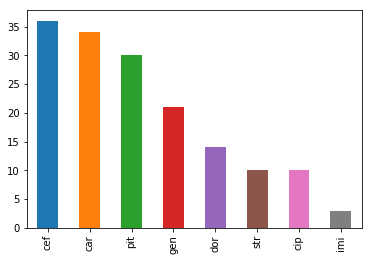

In [92]:
fig, ax = plt.subplots( nrows=1, ncols=1 )  # create figure & 1 axis
varmult['condition'].value_counts().plot.bar()


### Total number of variants per effect

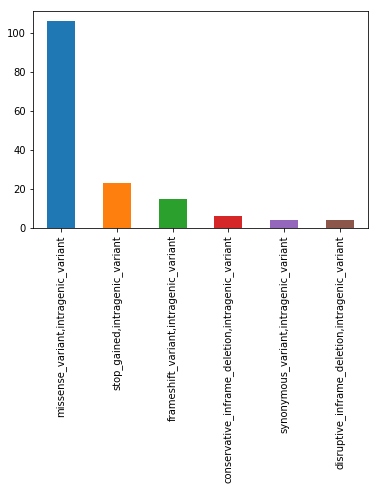

In [93]:
fig, ax = plt.subplots( nrows=1, ncols=1 )  # create figure & 1 axis
varmult['EFFECT'].value_counts().plot.bar()

### Number of variants per gene across all samples

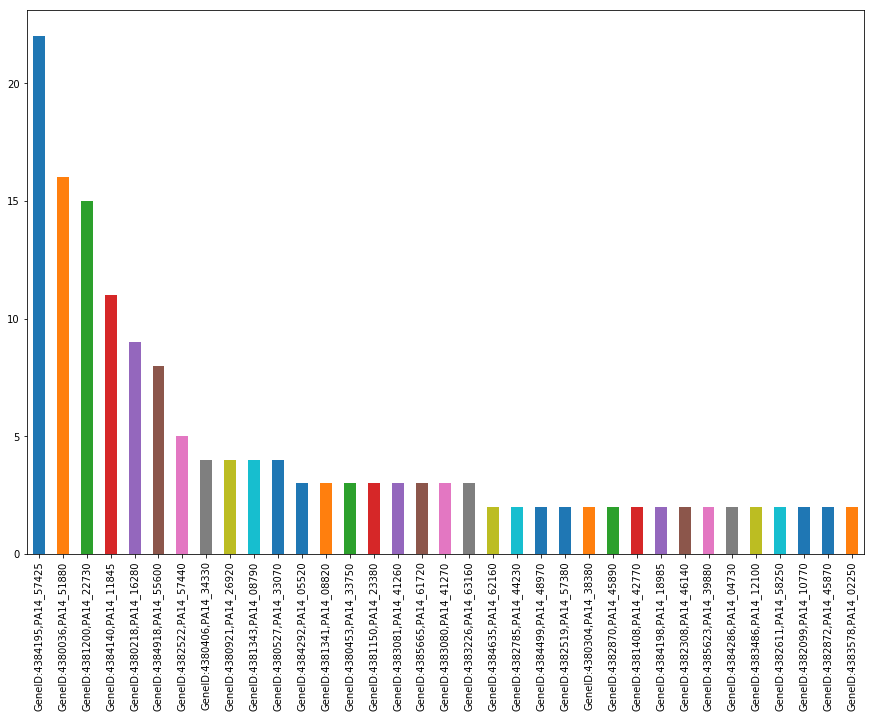

In [94]:
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(15, 10) )  # create figure & 1 axis
varmult['GENE'].value_counts().plot.bar()

### Number of variants per gene per condition

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34]), <a list of 35 Text xticklabel objects>)

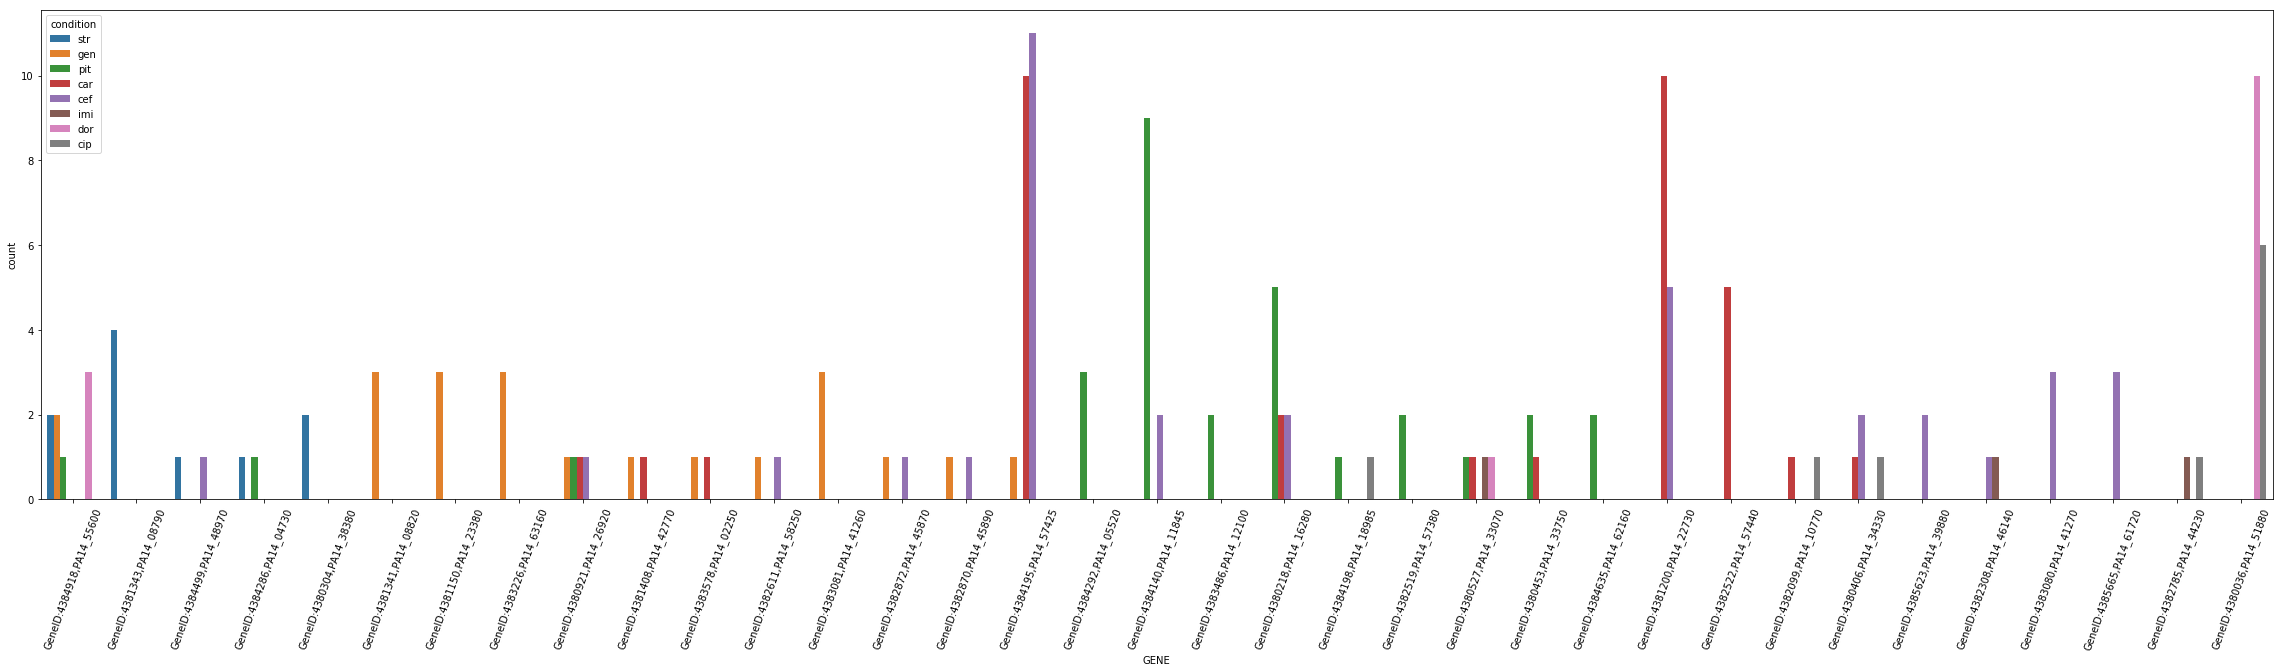

In [95]:
fig, ax = plt.subplots( nrows=1, ncols=1 ,figsize=(40, 9) )  # create figure & 1 axis
sns.countplot(x="GENE", hue="condition",data=pysqldf('SELECT condition, EFFECT, GENE FROM varmult'));
plt.xticks(rotation=70)

### Number of gene impacted per condition

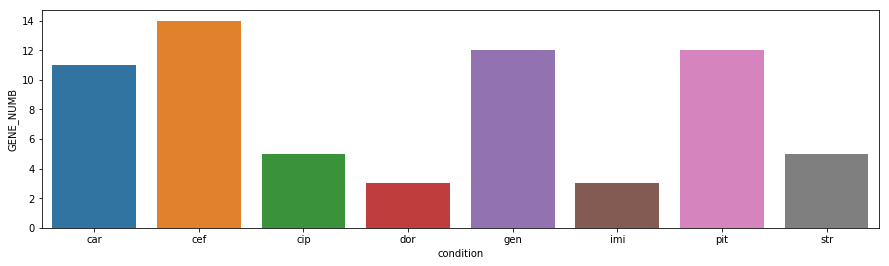

In [96]:
fig, ax = plt.subplots( nrows=1, ncols=1 ,figsize=(15, 4) )  # create figure & 1 axis
sns.barplot(x="condition", y="GENE_NUMB", data=pysqldf('SELECT condition, COUNT(DISTINCT UPPER(GENE)) AS GENE_NUMB  FROM varmult GROUP BY condition'));




### Number of sample having a variant at each position

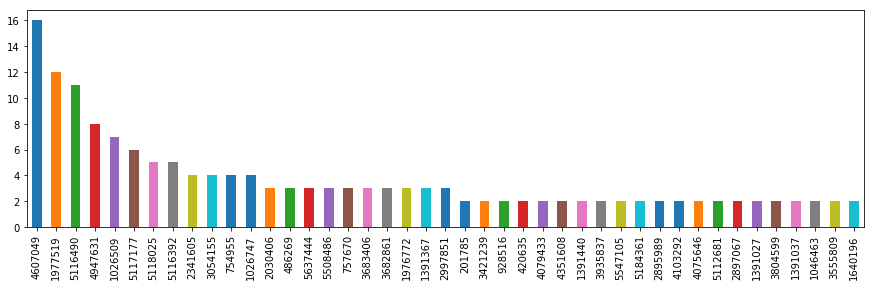

In [97]:
fig, ax = plt.subplots( nrows=1, ncols=1,figsize=(15, 4) )  # create figure & 1 axis
varmult['POS'].value_counts().plot.bar()


### Number of variants  per condition per effect

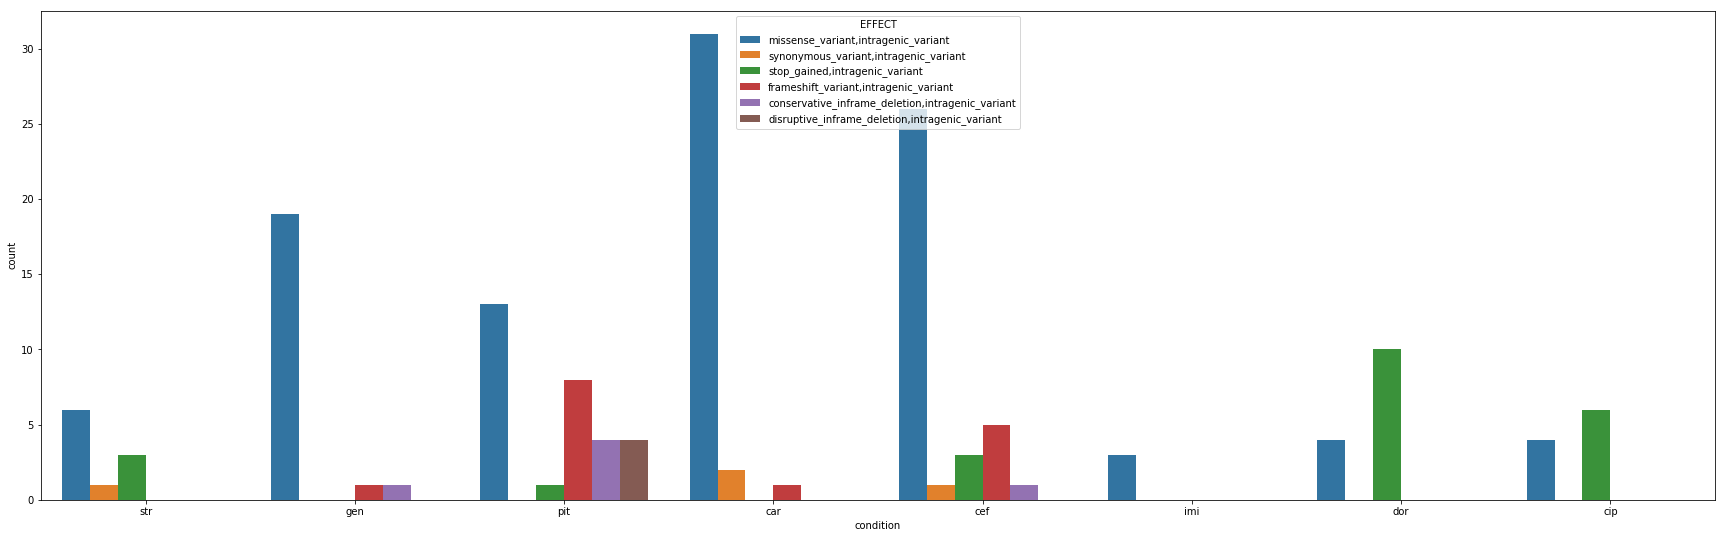

In [98]:
fig, ax = plt.subplots( nrows=1, ncols=1 ,figsize=(30, 9) )  # create figure & 1 axis
sns.countplot(x="condition", hue='EFFECT',data=pysqldf('SELECT * FROM varmult '));


### Number of variants per effect per condition

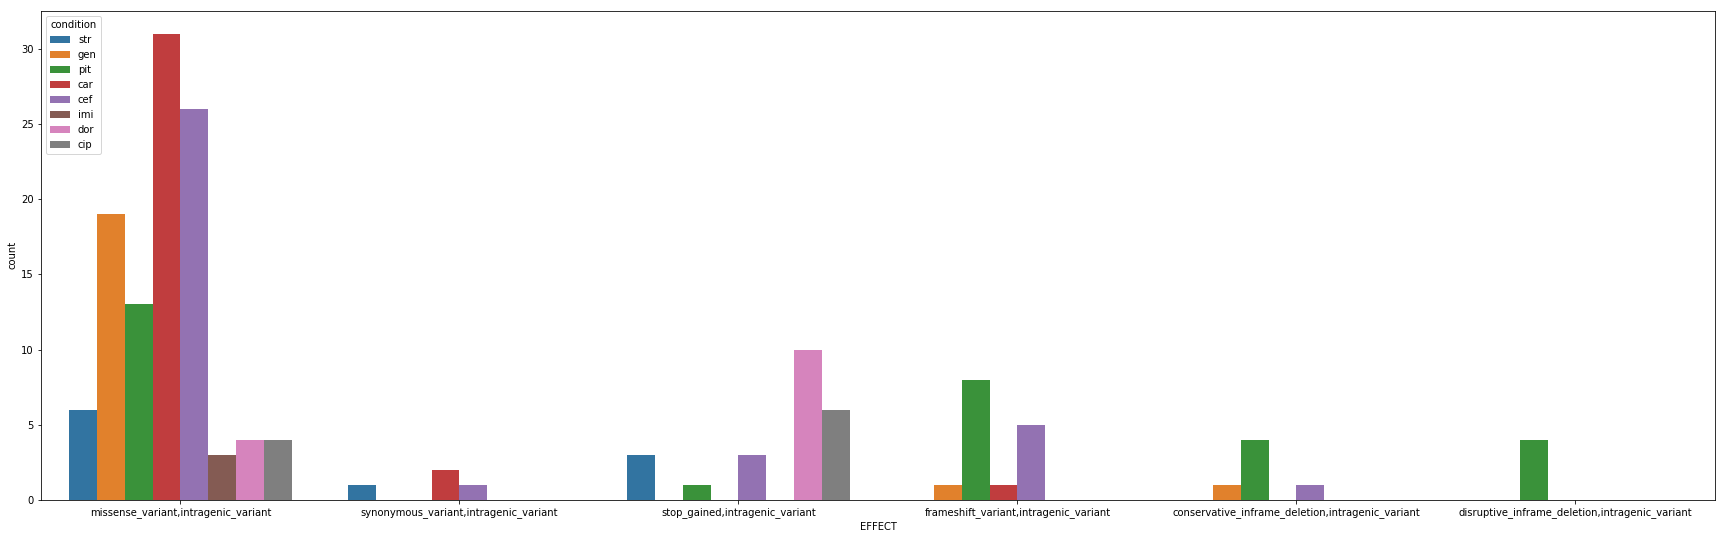

In [99]:
fig, ax = plt.subplots( nrows=1, ncols=1 ,figsize=(30, 9) )  # create figure & 1 axis
sns.countplot(x="EFFECT", hue='condition', data=pysqldf('SELECT * FROM varmult '));


### Number of variants per condition per impact

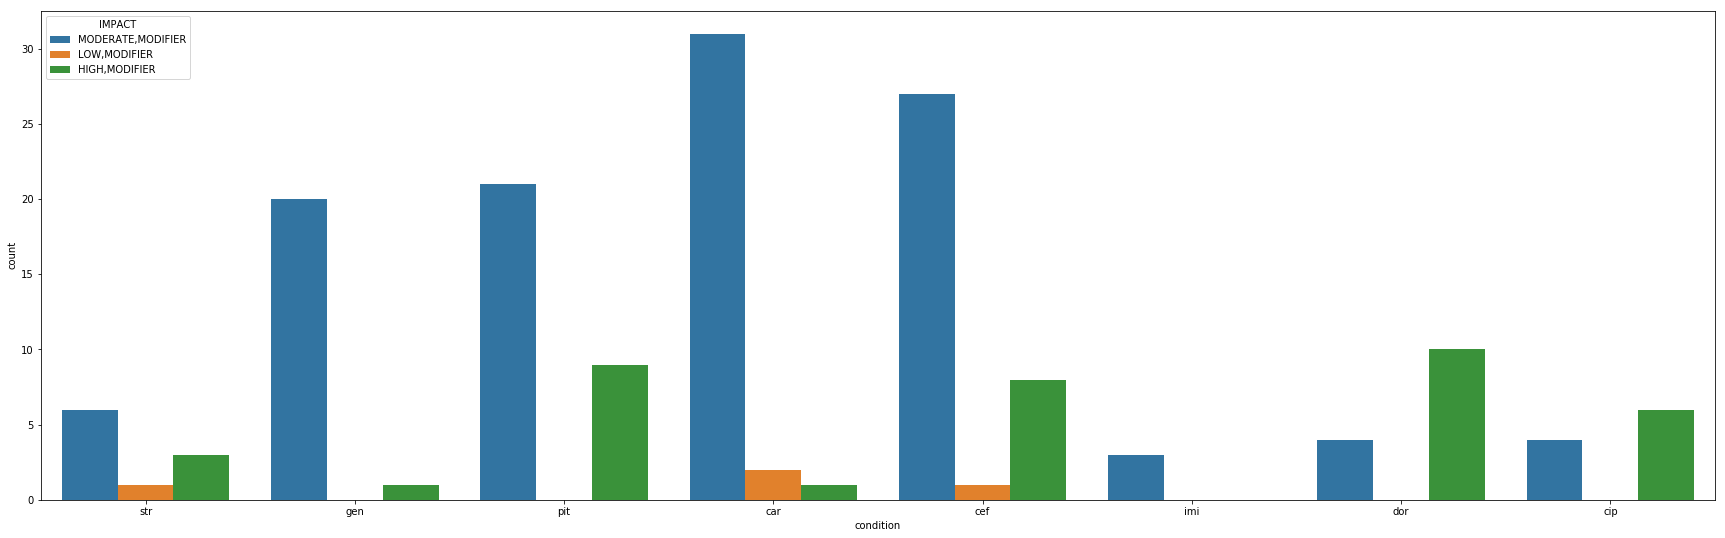

In [100]:
fig, ax = plt.subplots( nrows=1, ncols=1 ,figsize=(30, 9) )  # create figure & 1 axis
sns.countplot(x="condition", hue='IMPACT', data=pysqldf('SELECT * FROM varmult '));


### Number of variants per gene per position

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34]), <a list of 35 Text xticklabel objects>)

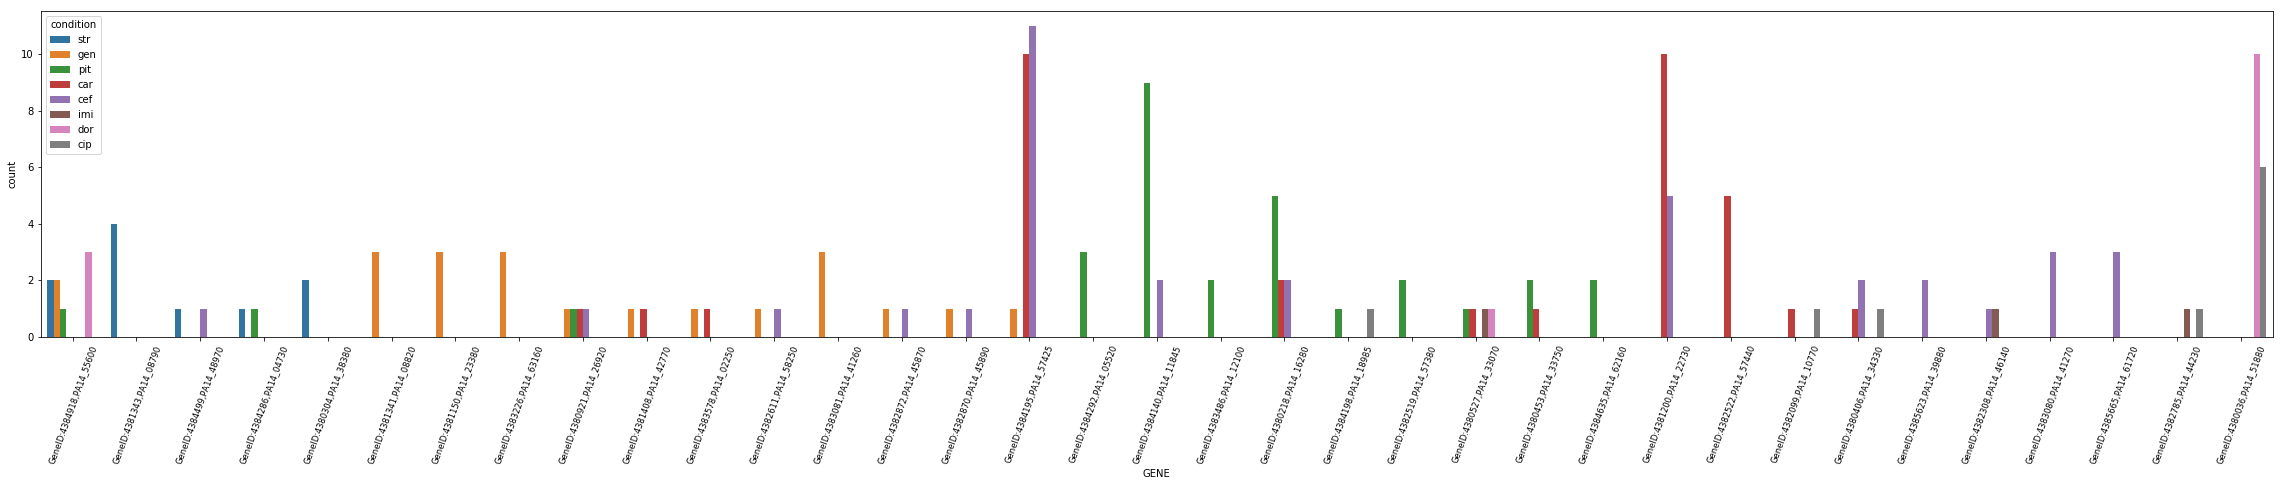

In [101]:
fig, ax = plt.subplots( nrows=1, ncols=1 ,figsize=(40, 6) )  # create figure & 1 axis
sns.countplot(x="GENE", hue='condition', data=pysqldf('SELECT * FROM varmult '));
plt.xticks(rotation=70, size='small')


In [102]:
sequences=joined.copy()

Get lists of Columns of interest :
 * A list of columns containing the sequence of reference
 * A list of collumn contining the gene impacted by the variation
 * A list of collumn contining the alternative sequence
 * A list containing the collumns we will need for this analysis


In [103]:
regexREF=re.compile(".*(REF).*")
listREF=filter(regexREF.match,joined.columns.values)
listsamples= [ i.replace('_fq_REF','') for i in listREF ]
regexGENE=re.compile(".*(GENE).*")
listGENE=filter(regexGENE.match,joined.columns.values)
regexALT=re.compile(".*(ALT).*")
listALT=filter(regexALT.match,joined.columns.values)
regexclean=re.compile(".*(_GENE)|(IMPACT)|(FUNCLASS).*")
listrefsalts=filter(lambda i: not regexclean.search(i),sequences.columns.values)


Keep only useful columns, delete the other ones

In [104]:
for i in listrefsalts[1:]:
    del sequences[i]

Creation of a Column that will contain the Gene impacted. Setting it at 'NaN' for the moment


In [106]:
listsamples= [ i.replace('_fq_REF','') for i in listREF ]
sequences['GENE']="NaN"

Parsing the dataframe to find a collumn containing the Gene impacted. Setting the 'GENE' column with its content

In [107]:
for i, row in sequences.iterrows() : 
    if int(row["POS"]) in multposlist:
        sequences=sequences.drop(i)
    else :
        for j in listGENE :
            if row[j]!='.':
                sequences.loc[i,('GENE')]=row[j]
                break

Deleting the collumns containing the gene impacted, now redundant with 'GENE' column

In [108]:
for i in listGENE:
    del sequences[i]



In the Dataframe, replacing the "IMPACT" column with numerical values depending on the strength of the effect : 
 * No variant results on a value of 0 impact
 * A Low impact variant with a "SILENT" Functional class results on a value of 0 impact
 * A Low impact variant results on a value of 100 impact
 * A Medium impact variant results on a value of 200 impact
 * A High impact variant results on a value of 300 impact
 * A Modifier variant results on a value of 50 impact

From http://snpeff.sourceforge.net/SnpEff_manual.html : 
    
| Impact | Meaning | Example |
| ------------ | ----------- | -----------: |
| HIGH | The variant is assumed to have high (disruptive) impact in the protein, probably causing protein truncation, loss of function or triggering nonsense mediated decay. | stop_gained, frameshift_variant |
| MODERATE      |   A non-disruptive variant that might change protein effectiveness.    | missense_variant, inframe_deletion |
| LOW |     Assumed to be mostly harmless or unlikely to change protein behavior.      | synonymous_variant |
| MODIFIER     |  Usually non-coding variants or variants affecting non-coding genes, where predictions are difficult or there is no evidence of impact.  | exon_variant, downstream_gene_variant |


In [109]:
for i, row in sequences.iterrows() :
    for j in listsamples :
        if row[j+'_fq_EFF_IMPACT']=='.':
            sequences.loc[i,(j+'_fq_EFF_IMPACT')]=0
        elif 'LOW'in  row[j+'_fq_EFF_IMPACT'] and 'SILENT'in row[j+'_fq_EFF_FUNCLASS'] :
            sequences.loc[i,(j+'_fq_EFF_IMPACT')]=0
        elif 'LOW'in  row[j+'_fq_EFF_IMPACT'] :
            sequences.loc[i,(j+'_fq_EFF_IMPACT')]=100
        elif 'MODERATE'in  row[j+'_fq_EFF_IMPACT'] :
            sequences.loc[i,(j+'_fq_EFF_IMPACT')]=200
        elif 'HIGH'in  row[j+'_fq_EFF_IMPACT'] :
            sequences.loc[i,(j+'_fq_EFF_IMPACT')]=300
        else : 
            sequences.loc[i,(j+'_fq_EFF_IMPACT')]=50
        

Removing the funclass columns

In [110]:
for j in listsamples :
    del sequences[j+'_fq_EFF_FUNCLASS']

Creating a Matrix grouping the variants by gene impacted : the different variant impacts are added for a result reflecting the global impact of all variants on one gene

In [111]:
#Creation of an empty matri with header = list of samples
filteredmatgene=pd.DataFrame(columns=sequences.columns.values[1:-1])
# Group rows by gene, summing the row content for collumns contining variants
filteredmatgene = sequences.groupby(['GENE'])[sequences.columns.values[1:-1]].sum()

Setting the gene collumn as inde to obtain a matrix containing only the strength of impoct for every gene for every sample

Calculation of distance Matrix 

In [112]:
#distance =  lambda column1, column2: pd.np.linalg.norm(column1 - column2) # Euclidian Distance
#distance = lambda column1, column2: scipy.stats.pearsonr(column1, column2)[0] # Pearson correlation coefficient
distance = lambda column1, column2: (column1 - column2).abs().sum() / len(column1) # % Difference
distdf = filteredmatgene.apply(lambda col1: matgene.apply(lambda col2: distance(col1, col2)))


Format the distance matrix to build a tree 

In [113]:
dstmattril=np.tril(distdf) # make it a lower triangular matrix
namessample= [str(x).replace("_fq_EFF_IMPACT","") for x in distdf.columns.values] #Remove unnecessary parts of sample names
# make it a list of lists 
dstmattril= [list(x) for x in dstmattril] 
altDistmat=list()
for i in range(0,len(distdf.columns.values)):
    altDistmat.append(dstmattril[i][:i+1])

Build a clustering tree from the distance matrix (Here using neighor joining algorithm) and save the tree in newinck format in a file

In [114]:

distmattree = DistanceMatrix(names=namessample, matrix=altDistmat)
constructor = DistanceTreeConstructor()
tree = constructor.nj(distmattree)
Phylo.write(tree,'test.nwk', 'newick')

1

### Draw Tree from a Newick File

Open Treefile

In [115]:
tree = Tree("test.nwk", format=1)

Set drawing style, title, and color per condition

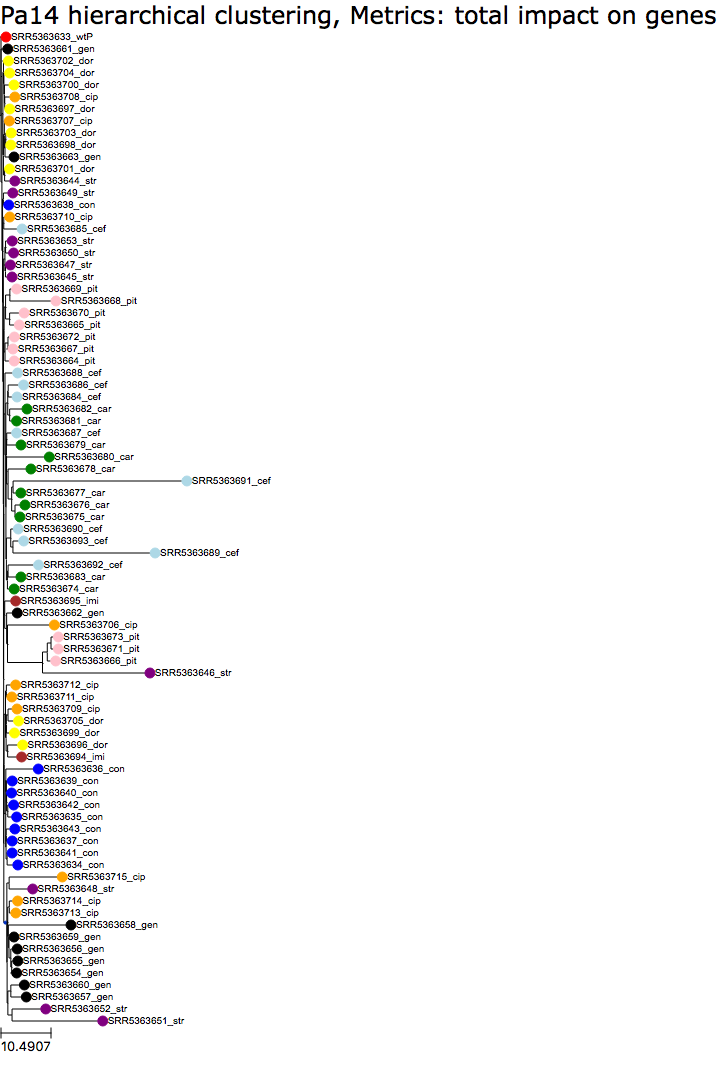

In [116]:
ts = TreeStyle()
ts.title.add_face(TextFace("Pa14 hierarchical clustering, Metrics: total impact on genes", fsize=24), column=0)
#ts.mode="c"
#ts.show_branch_length = False
ts.show_branch_support = False

for node in tree.traverse():
    node.img_style['size']=0
    if node.is_leaf():
        node.img_style['size']=10
        node.img_style["fgcolor"] = colorleaves[node.name]
                                                 
tree.set_outgroup("SRR5363633_wtP") # Set the wildtype as outgroup

tree.render("%%inline", tree_style=ts)

Render tree in the jupyter notebook

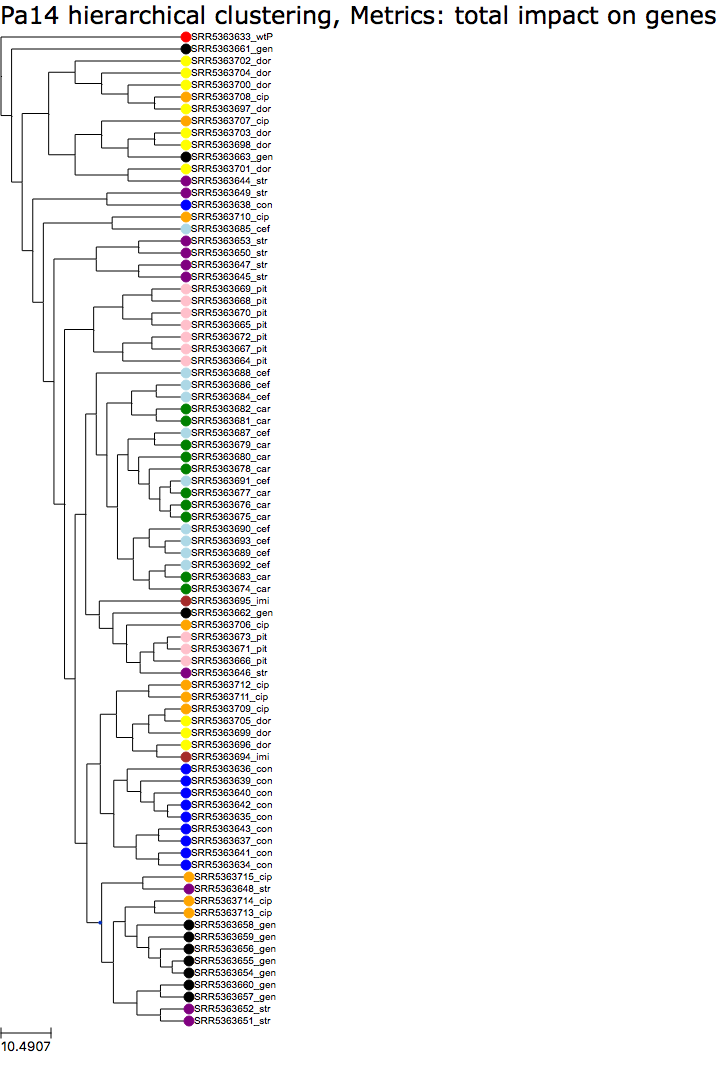

In [117]:
tree.convert_to_ultrametric(strategy='balanced')
tree.render("%%inline", tree_style=ts)


## Remove gene modified once

In [118]:
varsepgene = (var.drop('GENE', axis=1)
             .join
             (
             var.GENE
             .str
             .split(",",expand=True).replace(":","_")           
             ))


In [119]:
varsepgene=varsepgene.rename(index=str, columns={0:'GENE1'})


In [120]:
varsepgene=varsepgene.rename(index=str, columns={1:'GENE2'})

In [121]:
for i, row in varsepgene.iterrows() :
    varsepgene.loc[i,'GENE1']=varsepgene.loc[i,'GENE1'].replace(":","")

In [122]:
genecount=varsepgene['GENE1'].value_counts()
varmultgene=genecount[genecount>1]
multgenelist= list(varmultgene.index)
varsinglegene=genecount[genecount==1]
singlegenelist= list(varsinglegene.index)
varmult=pysqldf("SELECT * FROM varsepgene WHERE GENE1 IN ('"+"', '".join(multgenelist)+"') ")
varsingle=pysqldf("SELECT * FROM varsepgene WHERE GENE1 IN ( '"+"', '".join(singlegenelist)+"') ")

In [123]:
len(singleposlist)

934

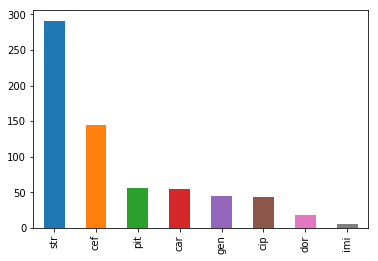

In [124]:
fig, ax = plt.subplots( nrows=1, ncols=1 )  # create figure & 1 axis
varmult['condition'].value_counts().plot.bar()


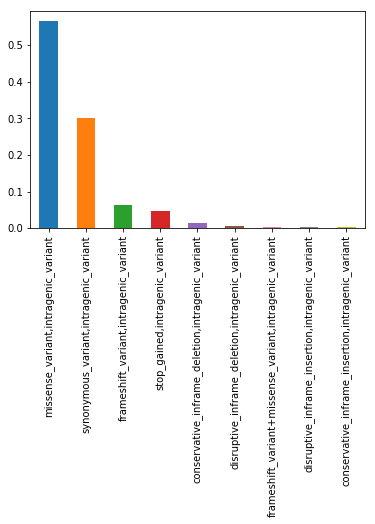

In [125]:
fig, ax = plt.subplots( nrows=1, ncols=1 )  # create figure & 1 axis
varmult['EFFECT'].value_counts(normalize=True).plot.bar()

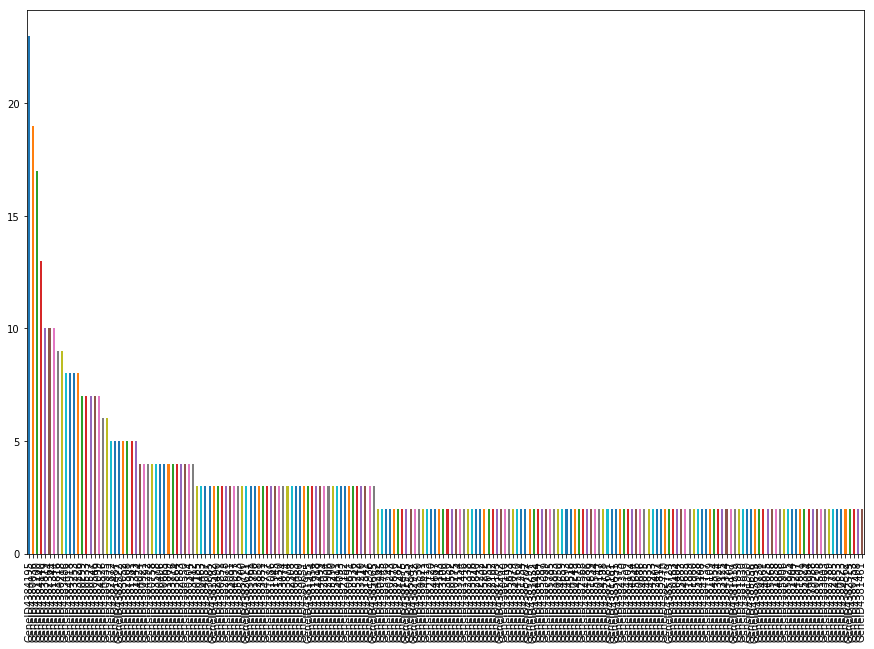

In [126]:
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(15, 10) )  # create figure & 1 axis
varmult['GENE1'].value_counts().plot.bar()

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

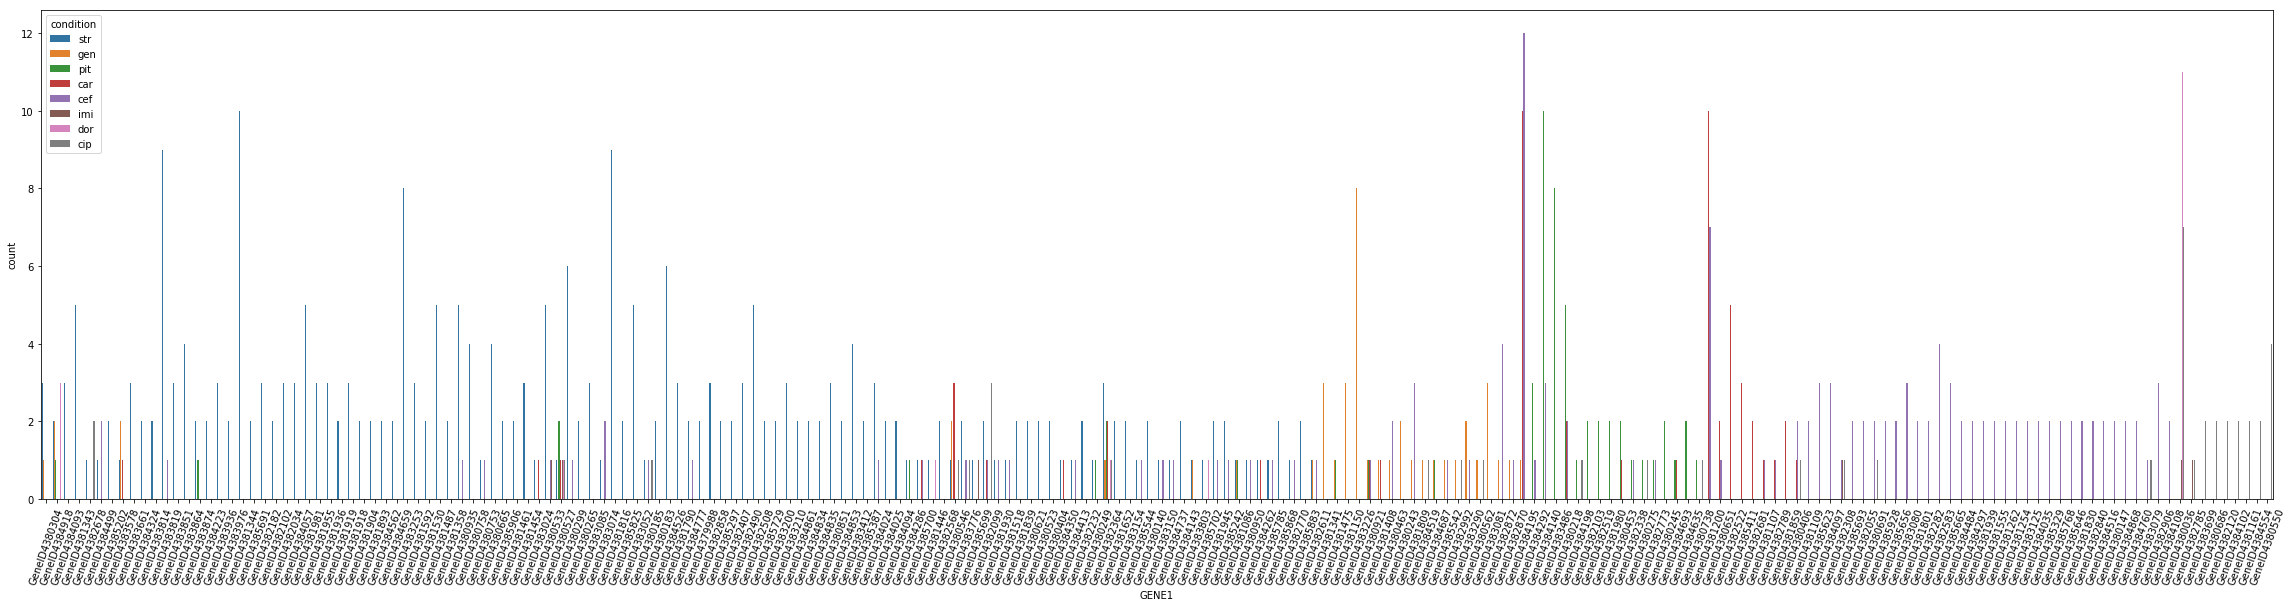

In [127]:
fig, ax = plt.subplots( nrows=1, ncols=1 ,figsize=(40, 9) )  # create figure & 1 axis
sns.countplot(x="GENE1", hue="condition",data=pysqldf('SELECT condition, EFFECT, GENE1 FROM varmult'));
plt.xticks(rotation=70)

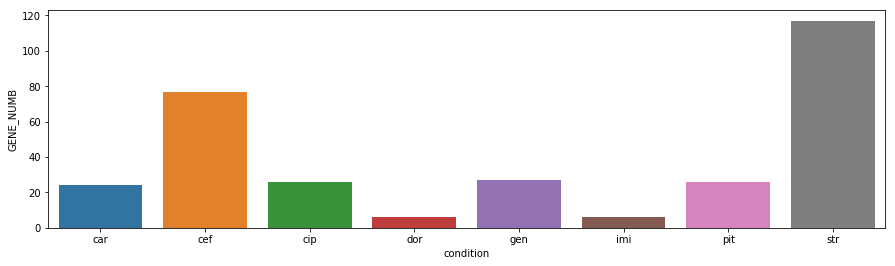

In [128]:
fig, ax = plt.subplots( nrows=1, ncols=1 ,figsize=(15, 4) )  # create figure & 1 axis
sns.barplot(x="condition", y="GENE_NUMB", data=pysqldf('SELECT condition, COUNT(DISTINCT UPPER(GENE1)) AS GENE_NUMB  FROM varmult GROUP BY condition'));




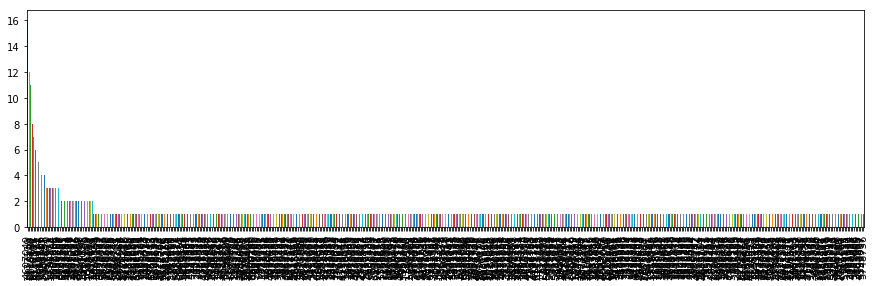

In [129]:
fig, ax = plt.subplots( nrows=1, ncols=1,figsize=(15, 4) )  # create figure & 1 axis
varmult['POS'].value_counts().plot.bar()


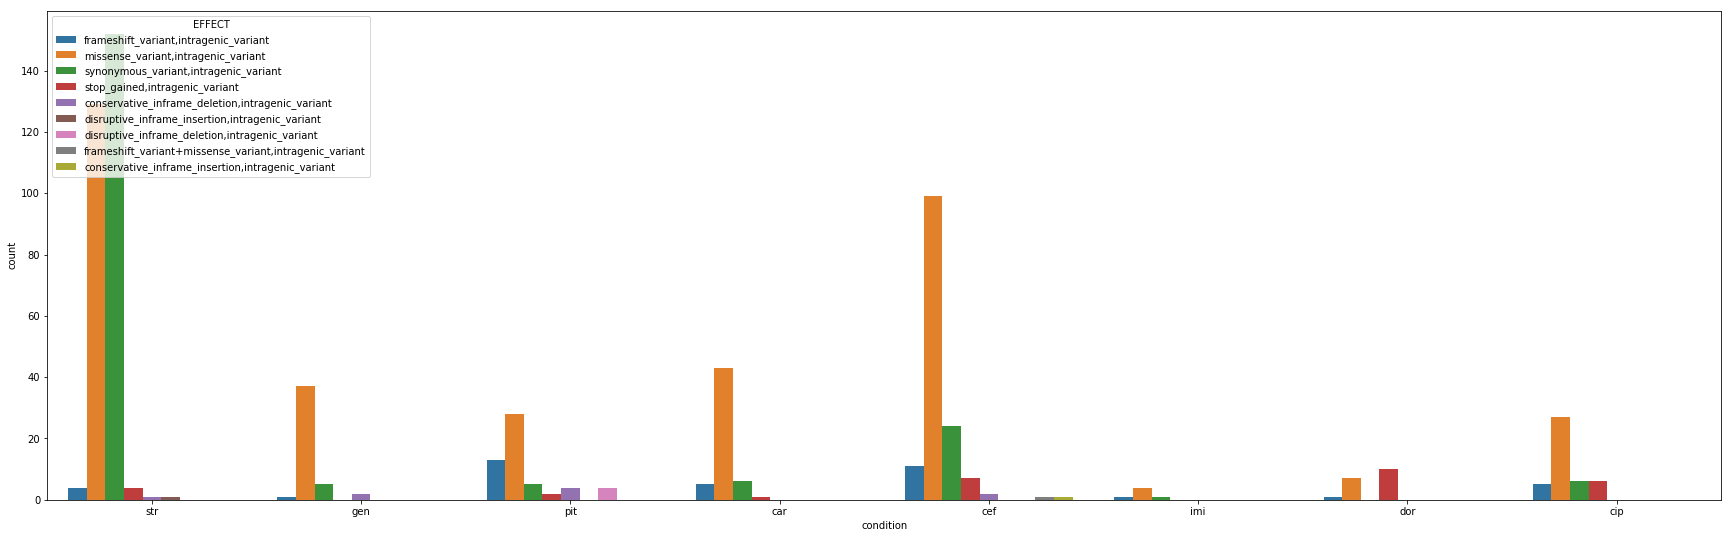

In [130]:
fig, ax = plt.subplots( nrows=1, ncols=1 ,figsize=(30, 9) )  # create figure & 1 axis
sns.countplot(x="condition", hue='EFFECT',data=pysqldf('SELECT * FROM varmult '));


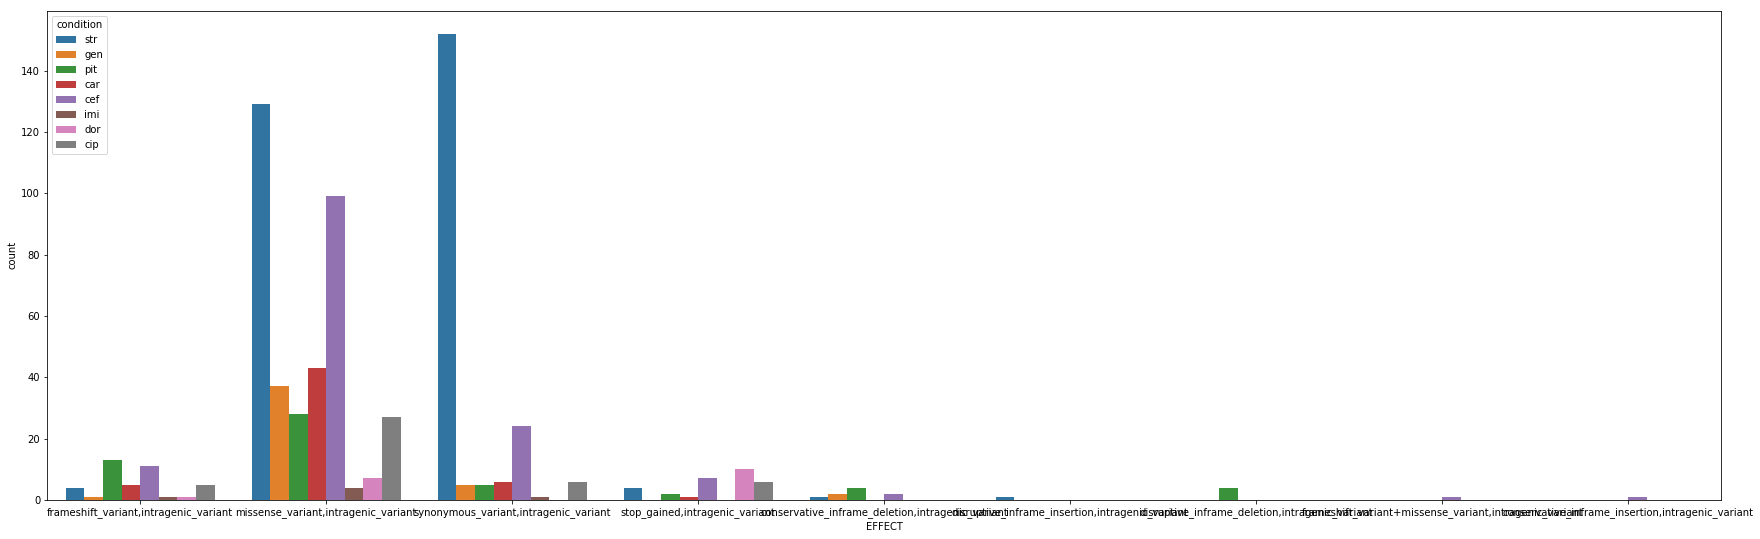

In [131]:
fig, ax = plt.subplots( nrows=1, ncols=1 ,figsize=(30, 9) )  # create figure & 1 axis
sns.countplot(x="EFFECT", hue='condition', data=pysqldf('SELECT * FROM varmult '));


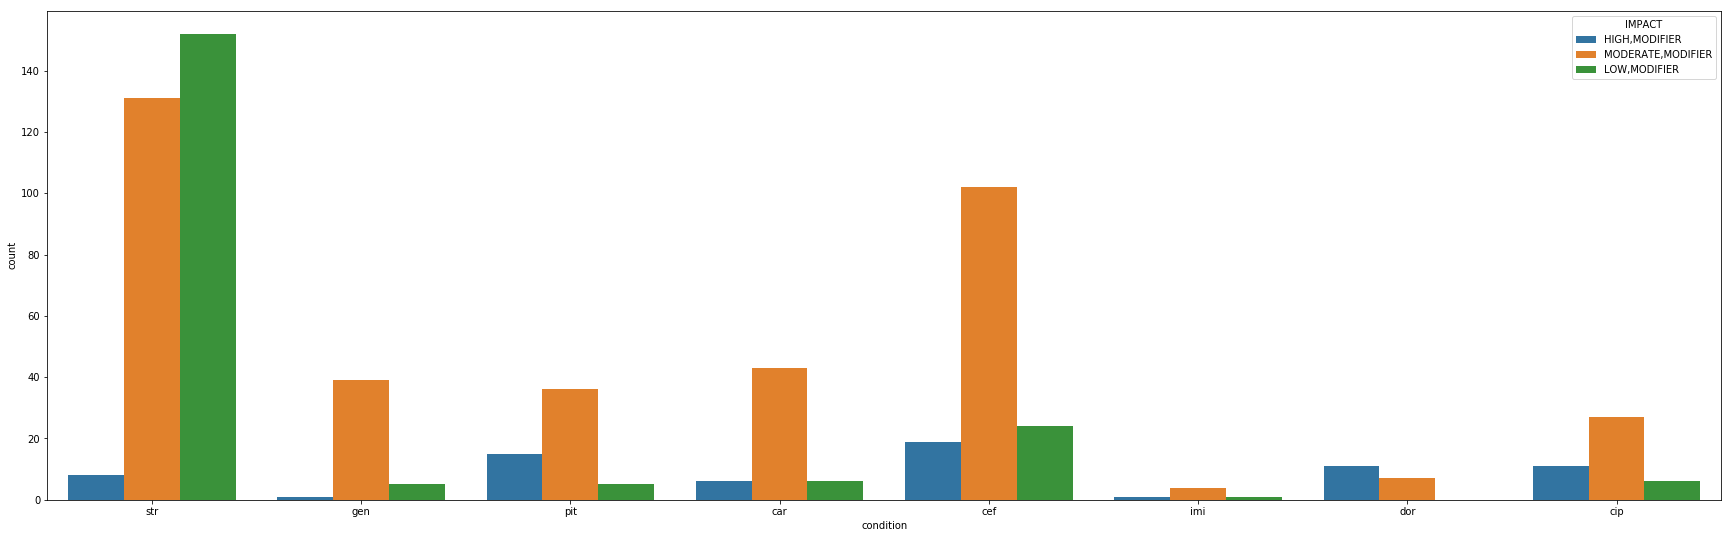

In [132]:
fig, ax = plt.subplots( nrows=1, ncols=1 ,figsize=(30, 9) )  # create figure & 1 axis
sns.countplot(x="condition", hue='IMPACT', data=pysqldf('SELECT * FROM varmult '));


(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

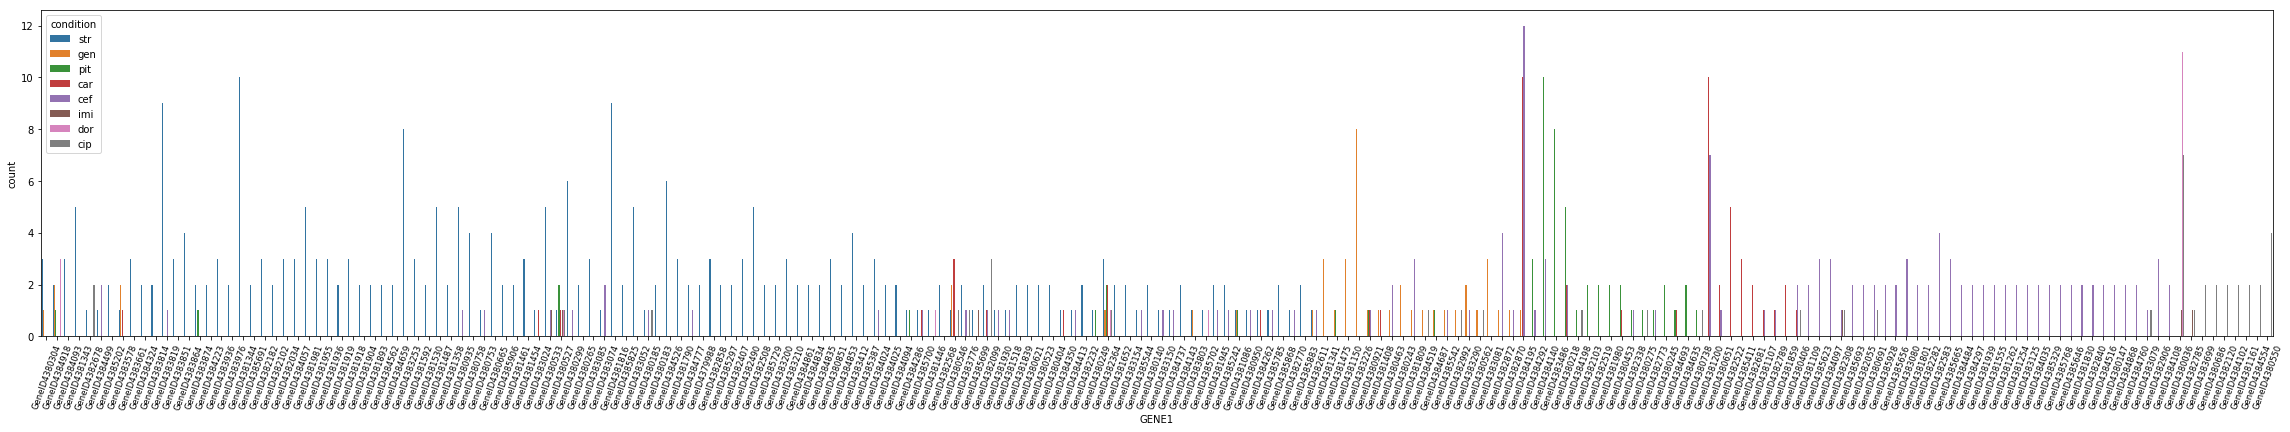

In [133]:
fig, ax = plt.subplots( nrows=1, ncols=1 ,figsize=(40, 6) )  # create figure & 1 axis
sns.countplot(x="GENE1", hue='condition', data=pysqldf('SELECT * FROM varmult '));
plt.xticks(rotation=70, size='small')


In [134]:
multpos=varmult['POS'].unique()


In [135]:
sequences=joined.copy()

Get lists of Columns of interest :
 * A list of columns containing the sequence of reference
 * A list of collumn contining the gene impacted by the variation
 * A list of collumn contining the alternative sequence
 * A list containing the collumns we will need for this analysis


In [136]:
regexREF=re.compile(".*(REF).*")
listREF=filter(regexREF.match,joined.columns.values)
listsamples= [ i.replace('_fq_REF','') for i in listREF ]
regexGENE=re.compile(".*(GENE).*")
listGENE=filter(regexGENE.match,joined.columns.values)
regexALT=re.compile(".*(ALT).*")
listALT=filter(regexALT.match,joined.columns.values)
regexclean=re.compile(".*(_GENE)|(IMPACT)|(FUNCLASS).*")
listrefsalts=filter(lambda i: not regexclean.search(i),sequences.columns.values)


Keep only useful columns, delete the other ones

In [137]:
for i in listrefsalts[1:]:
    del sequences[i]

In [138]:
for i in listsamples:
    del sequences[i+"_fq_EFF_IMPACT_1"]

KeyError: 'SRR5363633_wtP_fq_EFF_IMPACT_1'

Creation of a Column that will contain the Gene impacted. Setting it at 'NaN' for the moment


In [ ]:
listsamples= [ i.replace('_fq_REF','') for i in listREF ]
sequences['GENE']="NaN"

Parsing the dataframe to find a collumn containing the Gene impacted. Setting the 'GENE' column with its content

In [ ]:
for i, row in sequences.iterrows() : 
    if int(row["POS"]) in multpos:
        sequences=sequences.drop(i)
    else :
        for j in listGENE :
            if row[j]!='.':
                sequences.loc[i,('GENE')]=row[j]
                break

Deleting the collumns containing the gene impacted, now redundant with 'GENE' column

In [ ]:
for i in listGENE:
    del sequences[i]



In the Dataframe, replacing the "IMPACT" column with numerical values depending on the strength of the effect : 
 * No variant results on a value of 0 impact
 * A Low impact variant with a "SILENT" Functional class results on a value of 0 impact
 * A Low impact variant results on a value of 100 impact
 * A Medium impact variant results on a value of 200 impact
 * A High impact variant results on a value of 300 impact
 * A Modifier variant results on a value of 50 impact

From http://snpeff.sourceforge.net/SnpEff_manual.html : 
    
| Impact | Meaning | Example |
| ------------ | ----------- | -----------: |
| HIGH | The variant is assumed to have high (disruptive) impact in the protein, probably causing protein truncation, loss of function or triggering nonsense mediated decay. | stop_gained, frameshift_variant |
| MODERATE      |   A non-disruptive variant that might change protein effectiveness.    | missense_variant, inframe_deletion |
| LOW |     Assumed to be mostly harmless or unlikely to change protein behavior.      | synonymous_variant |
| MODIFIER     |  Usually non-coding variants or variants affecting non-coding genes, where predictions are difficult or there is no evidence of impact.  | exon_variant, downstream_gene_variant |


In [ ]:
for i, row in sequences.iterrows() :
    for j in listsamples :
        if row[j+'_fq_EFF_IMPACT']=='.':
            sequences.loc[i,(j+'_fq_EFF_IMPACT')]=0
        elif 'LOW'in  row[j+'_fq_EFF_IMPACT'] and 'SILENT'in row[j+'_fq_EFF_FUNCLASS'] :
            sequences.loc[i,(j+'_fq_EFF_IMPACT')]=0
        elif 'LOW'in  row[j+'_fq_EFF_IMPACT'] :
            sequences.loc[i,(j+'_fq_EFF_IMPACT')]=100
        elif 'MODERATE'in  row[j+'_fq_EFF_IMPACT'] :
            sequences.loc[i,(j+'_fq_EFF_IMPACT')]=200
        elif 'HIGH'in  row[j+'_fq_EFF_IMPACT'] :
            sequences.loc[i,(j+'_fq_EFF_IMPACT')]=300
        else : 
            sequences.loc[i,(j+'_fq_EFF_IMPACT')]=50
        

Removing the funclass columns

In [ ]:
for j in listsamples :
    del sequences[j+'_fq_EFF_FUNCLASS']

Creating a Matrix grouping the variants by gene impacted : the different variant impacts are added for a result reflecting the global impact of all variants on one gene

In [ ]:
#Creation of an empty matri with header = list of samples
matgene=pd.DataFrame(columns=sequences.columns.values[1:-1])
# Group rows by gene, summing the row content for collumns contining variants
matgene = sequences.groupby(['GENE'])[sequences.columns.values[1:-1]].sum()

Setting the gene collumn as inde to obtain a matrix containing only the strength of impoct for every gene for every sample

Calculation of distance Matrix 

In [ ]:
#distance =  lambda column1, column2: pd.np.linalg.norm(column1 - column2) # Euclidian Distance
#distance = lambda column1, column2: scipy.stats.pearsonr(column1, column2)[0] # Pearson correlation coefficient
distance = lambda column1, column2: (column1 - column2).abs().sum() / len(column1) # % Difference
distdf = matgene.apply(lambda col1: matgene.apply(lambda col2: distance(col1, col2)))


Format the distance matrix to build a tree 

In [ ]:
dstmattril=np.tril(distdf) # make it a lower triangular matrix
namessample= [str(x).replace("_fq_EFF_IMPACT","") for x in distdf.columns.values] #Remove unnecessary parts of sample names
# make it a list of lists 
dstmattril= [list(x) for x in dstmattril] 
altDistmat=list()
for i in range(0,len(distdf.columns.values)):
    altDistmat.append(dstmattril[i][:i+1])

Build a clustering tree from the distance matrix (Here using neighor joining algorithm) and save the tree in newinck format in a file

In [ ]:

distmattree = DistanceMatrix(names=namessample, matrix=altDistmat)
constructor = DistanceTreeConstructor()
tree = constructor.nj(distmattree)
Phylo.write(tree,'test.nwk', 'newick')

### Draw Tree from a Newick File

Open Treefile

In [ ]:
tree = Tree("test.nwk", format=1)

Set drawing style, title, and color per condition

In [ ]:

ts = TreeStyle()
ts.title.add_face(TextFace("Pa14 hierarchical clustering, Metrics: total impact on genes", fsize=24), column=0)
#ts.mode="c"
#ts.show_branch_length = False
ts.show_branch_support = False

for node in tree.traverse():
    node.img_style['size']=0
    if node.is_leaf():
        node.img_style['size']=10
        node.img_style["fgcolor"] = colorleaves[node.name]
                                                 
tree.set_outgroup("SRR5363633_wtP") # Set the wildtype as outgroup

tree.render("%%inline", tree_style=ts)

Render tree in the jupyter notebook

In [ ]:
tree.convert_to_ultrametric(strategy='balanced')
tree.render("%%inline", tree_style=ts)
